Привет, Евгения! 

Меня зовут Светлана Медведева и я буду проверять Твою работу. Предлагаю общаться на "ты". Если Тебе такой вариант не удобен, то пожалуйста дай знать. Я сразу перейду на "Вы".

При обнаружении у Тебя в работе ошибки, в первый раз я лишь укажу на ее наличие и у Тебя будет возможность самому найти её и исправить. В реальной работе твой начальник будет поступать также, а я пытаюсь подготовить тебя именно к работе Data Scientist. Однако, если ты пока не справишься с такой задачей - при следующей проверке я дам более точную подсказку.

Просьба при доработке работы оставлять мои комментарии без изменений.

Комментарии я разделяю на следующие категории:

<div class="alert alert-block alert-success">
В случае если всё верно!
</div>


<div class="alert alert-block alert-warning">
В случае если можно что-то доработать, но эта доработка не критична или если есть варианты улучшения работы.
</div>

<div class="alert alert-block alert-danger">
Критичные замечания. Если бы проект сдавался за несколько итераций, то с красными замечаниями проект не был бы принят.
</div>

<div class="alert alert-block alert-info">
Дополнительные материалы, выходящие за рамки программы.
</div>

## Ревью:

У тебя отличная работа, предобработка данных проведена,модели обучены и выводы сфомулированы. Дополнительно можно расмотреть несколько подходов к отбору признаков. Молодец, что добавила рекомендации по улучшению качества прогноза.

Успехов!

# Мэтчинг товаров

## Описание проекта

### Исходные данные

- base.csv - датасет со всеми товарами. У каждого товара есть уникальный id (пример 4207931-base) и 72 признака.
- train.csv - обучающий датасет, содержит индексы наиболее подходящих товаров-аналогов.
- validation.csv - валидационный датасет для проверки финального алгоритма, содердт товары, где которых надо найти аналоги из base.csv
- validation_answer.csv - валидационный датасет с разметкой наиболее подходящих товаров.

Все датасеты есть в полной и сокращенной версии.

###Что надо сделать?

- разработать алгоритм, который предложит 5 наиболее похожих товаров из df_base для каждого товара из df_valid
- оценить качество алгоритма по метрике `accuracy@5`

###План работы:

1. Загрузка уменьшенного датасета
2. Посмотреть результат FAISS на необработанных данных
3. Предобработка данных
4. Кластеризация
5. Поиск ближайших соседей (KNN, тестирование разных межкластерных расстояний и faiss cpu gpu)
6. Оценка качества работы алгоритма на validation
7. Отбор важных признаков
8. Поиск ближайших соседей + оценка качества подбора
9. Разделить кластеры на подкластеры
10. Оценка качества работы алгоритма на validation
11. Проверка финального алгоритма на большом датасете
12. Выводы


<div class="alert alert-block alert-success">

Молодец, что сформулировала цель проекта, описала данные и составила план работ 👍👍👍
</div>

In [1]:
!pip install faiss-cpu

zsh:1: command not found: pip


In [2]:
!apt -q install libomp-dev
!pip -q install faiss-gpu

zsh:1: command not found: apt
zsh:1: command not found: pip


<div class="alert alert-block alert-success">

Ок, необходимые библиотеки установлены
</div>

In [3]:
#импортирую библиотеки

import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import requests
import os
from urllib.parse import urlencode
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'faiss'

<div class="alert alert-block alert-success">

Отлично, что используешь .set_option. Опции удобно использовать для задания общего стиля оформления.
    
Дополнительно можно посмотреть: https://habr.com/ru/articles/521894/
</div>

In [ ]:
def downloader(size: str='small'):
    if size not in ['small', 'large']:
        raise Exception('Unknown Argument')
    elif size == 'small':
        public_key = 'https://disk.yandex.ru/d/YQElc_cNQQLSOw'
    else:
        public_key = 'https://disk.yandex.ru/d/BBEphK0EHSJ5Jw'

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    with open('/content/data.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = ('/content/data.zip')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

<div class="alert alert-block alert-warning">

При написании кода рекомендую придерживаться правил оформления кода PEP8 и добавлять к функциям документацию, так называемые docstrings.

Подробнее: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
</div>

In [ ]:
%%time
downloader('small')

CPU times: user 3.13 s, sys: 1.08 s, total: 4.22 s
Wall time: 13.5 s


In [ ]:
%%time
df_base = pd.read_csv("base.csv", index_col=0)
df_base.head()

CPU times: user 7.44 s, sys: 494 ms, total: 7.94 s
Wall time: 8.22 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,45.090958,-126.84374,4.494522,-99.842310,44.926903,177.52173,-12.291790,38.470360,105.357650,-142.46024,-80.163260,-110.368935,1047.517357,-69.594620,66.313540,84.873870,813.770071,-81.038780,16.162964,-98.244880,159.53406,27.554913,-209.184280,62.05977,-529.295053,114.598330,90.469894,-20.256914,-164.76800,-133.31387,-41.252960,-10.251193,8.289038,-131.312710,75.704500,-16.483078,40.771038,-146.096740,-143.407680,49.807987,63.434480,-30.250080,20.470263,78.079910,-128.915310,92.327680,63.885570,-141.17464,142.902590,-93.068596,-568.421584,-90.018690,-129.015670,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,201.472200,-186.22650,29.896042,-99.770996,0.126302,136.19049,-35.224740,-30.321323,-43.148834,-162.85175,-79.714510,-75.784870,1507.231274,-69.654564,43.640663,-4.779669,813.770071,43.976913,11.924875,-50.228523,166.00820,-59.505333,-115.332520,72.18324,-735.671365,96.322300,85.796360,-22.030330,-147.54501,-108.38295,-45.084892,-15.004004,-1.532826,-46.456585,197.578950,-56.199876,60.298710,-102.653340,-108.967964,58.512012,-9.678028,-85.448300,-68.686080,71.590200,-232.425690,91.706856,63.290657,-137.33595,-47.124687,-148.057400,-543.787056,-160.651600,-133.462220,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,105.715180,-149.80756,-54.501680,-21.037973,-24.887660,128.38864,-58.558483,34.862656,19.784412,-130.91820,-79.032230,-166.635250,1507.231274,-8.495993,61.205086,25.895348,813.770071,-140.768860,20.872790,-123.957570,126.34781,11.713674,-125.025154,152.68590,-1018.469545,-22.444600,73.897640,9.190645,-156.51881,-92.18573,-34.926760,-13.277475,16.026424,-33.853546,119.604520,-52.525341,71.204750,-178.702940,-88.278500,30.501453,16.651737,-88.377014,-55.883583,70.182980,-89.233925,92.005780,76.458725,-131.14087,40.914352,-157.900540,-394.319235,-87.107025,-120.772545,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,110.324326,-161.18800,-68.519790,-0.607330,38.733696,120.74344,-14.109269,28.868027,-29.858810,-94.30395,-79.339810,-138.984270,1507.231274,-131.885380,70.031360,32.736595,813.770071,-62.370860,13.763219,-31.872276,139.55270,9.836465,-150.221130,80.14020,-537.183707,3.091667,129.699330,-63.429424,-169.02724,-119.77007,-28.637785,-8.315162,2.752385,-160.293820,85.086890,-18.251750,90.374054,1.479935,-121.983050,65.852660,8.355225,34.118896,-57.069756,70.461800,-127.905410,94.314280,71.259940,-135.57787,-39.982346,-159.751560,-230.147648,-95.221160,-148.814090,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,191.465850,-156.98384,-76.650210,-75.674970,12.624029,145.33752,-35.774258,11.598761,-11.460761,-201.35443,-77.779366,-120.968400,548.736883,19.851685,17.943344,27.063320,813.770071,-85.483780,21.236433,-95.071020,132.61092,13.526038,-160.476840,104.71937,-304.174382,-15.385452,91.418655,-36.474556,-157.43959,-102.83162,-56.782710,-19.969252,-0.598189,-222.228790,33.441666,-56.092110,71.276030,-8.713509,-86.099380,8.488903,-14.959278,86.812996,-29.6

In [ ]:
df_base.shape

(291813, 72)

In [ ]:
df_train = pd.read_csv("train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,131.131700,-149.211060,-102.31221,21.387623,11.277594,143.22140,-22.011570,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.008150,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.095570,133.786470,-906.571061,113.355560,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.647720,167.735820,-32.931559,47.860960,-196.247500,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.513430,-136.27057,3.652915,-164.574510,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,76.202880,-137.799420,33.30165,-2.868191,-34.318770,189.06479,-19.337550,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.128620,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.055180,113.819870,-529.295053,70.674940,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.499200,144.650200,-37.903276,58.913525,-105.362840,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.926130,-135.68242,-7.429803,-180.645020,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,112.190155,-200.925960,-38.86518,-80.611270,14.343805,156.62129,-22.498169,-26.359468,-109.034870,-106.92659,-79.74731,-69.876830,1507.231274,-20.058287,34.334927,23.592144,813.770071,-49.503860,22.166200,-85.740160,134.83647,-69.569850,-139.887240,67.377045,-341.781842,54.161224,81.891660,36.421352,-159.99583,-131.916080,-20.495195,-13.976569,-2.355247,-216.228650,238.836490,-56.611536,43.366640,7.191841,-159.48369,-19.338009,-51.409897,36.819540,32.536880,80.681020,-232.40741,84.053690,59.086180,-139.85950,78.409440,-115.940575,2.426572,7.594826,-126.520134,-73.148960,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,120.074790,-61.347084,-28.67060,-102.790180,-36.194320,157.18976,-33.318240,7.448413,-47.230713,-178.04608,-78.78652,-106.235440,1507.231274,-63.414307,38.099255,-89.795350,813.770071,-107.432390,10.052701,-71.917380,147.74005,-18.750763,-143.795620,67.207310,-366.139446,112.187700,78.144810,-41.085410,-132.75719,-89.445030,-19.267069,-14.866466,7.775788,-104.302110,74.622894,-59.875136,76.406470,-77.797020,-92.01658,19.337300,-37.922787,37.271270,111.639570,94.912950,-179.72540,86.601480,62.698364,-122.16293,29.873940,-53.508120,-0.938894,-36.919907,-144.555000,-96.798590,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,172.365360,-186.641390,-84.94380,-92.339966,-30.229528,167.86163,-22.635653,0.014536,-9.796367,-213.10180,-78.59006,-98.728300,1250.423749,-43.892487,86.288450,-1.549826,813.770071,-110.356980,24.055641,-96.578270,156.58230,45.124240,-123.888504,118.035110,-607.946912,52.311410,76.747800,-14.161914,-143.53851,-124.886215,-64.783330,-17.706848,15.446568,-53.554455,174.381620,-23.140892,76.419330,-73.

In [ ]:
df_train.shape

(9999, 73)

In [ ]:
df_valid = pd.read_csv("validation.csv", index_col=0)
answers = pd.read_csv("validation_answer.csv", index_col=0)
df_valid.shape

(10000, 72)

In [ ]:
answers.head()

,Expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


Каждый товар характеризуется 71 признаком, данные уже оработаны, признаки анимизированы, поэтому работать с ними можно только с точки зрения работы с данными, отбирать важные признаки, полагаясь на интуицию, не получится.

Посмотрим на результат FAISS без предобработки данных. Это будет базовый результат, который мы будем улучшать по ходу проекта.

##FAISS на сырых данных

<div class="alert alert-block alert-success">

Да, логично:)
</div>

In [ ]:
dims_0 = df_base.shape[1]
n_cells = 20
quantizer = faiss.IndexFlatL2(dims_0)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims_0, n_cells)

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

CPU times: user 618 ms, sys: 210 ms, total: 828 ms
Wall time: 635 ms


In [ ]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [ ]:
targets_0 = df_train["Target"]
df_train_0 = df_train.drop("Target", axis=1)


In [ ]:
%%time
candidate_number = 5
r, idx = idx_l2.search(np.ascontiguousarray(df_train_0.values).astype('float32'), candidate_number)

CPU times: user 9.38 s, sys: 16.7 ms, total: 9.39 s
Wall time: 8.03 s


In [ ]:
acc = 0
for target, el in zip(targets_0.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 11.5%


До всех обработок целевая метрика 11.5%. Будем работать над ее улучшением.


<div class="alert alert-block alert-success">

Отлично, baseline модель построена 👍👍👍
</div>

##Изучение данных


In [ ]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float64
 1   1       291813 non-null  float64
 2   2       291813 non-null  float64
 3   3       291813 non-null  float64
 4   4       291813 non-null  float64
 5   5       291813 non-null  float64
 6   6       291813 non-null  float64
 7   7       291813 non-null  float64
 8   8       291813 non-null  float64
 9   9       291813 non-null  float64
 10  10      291813 non-null  float64
 11  11      291813 non-null  float64
 12  12      291813 non-null  float64
 13  13      291813 non-null  float64
 14  14      291813 non-null  float64
 15  15      291813 non-null  float64
 16  16      291813 non-null  float64
 17  17      291813 non-null  float64
 18  18      291813 non-null  float64
 19  19      291813 non-null  float64
 20  20      291813 non-null  float64
 21 

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float64
 1   1       9999 non-null   float64
 2   2       9999 non-null   float64
 3   3       9999 non-null   float64
 4   4       9999 non-null   float64
 5   5       9999 non-null   float64
 6   6       9999 non-null   float64
 7   7       9999 non-null   float64
 8   8       9999 non-null   float64
 9   9       9999 non-null   float64
 10  10      9999 non-null   float64
 11  11      9999 non-null   float64
 12  12      9999 non-null   float64
 13  13      9999 non-null   float64
 14  14      9999 non-null   float64
 15  15      9999 non-null   float64
 16  16      9999 non-null   float64
 17  17      9999 non-null   float64
 18  18      9999 non-null   float64
 19  19      9999 non-null   float64
 20  20      9999 non-null   float64
 21  21      9999 non-null   

In [ ]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float64
 1   1       10000 non-null  float64
 2   2       10000 non-null  float64
 3   3       10000 non-null  float64
 4   4       10000 non-null  float64
 5   5       10000 non-null  float64
 6   6       10000 non-null  float64
 7   7       10000 non-null  float64
 8   8       10000 non-null  float64
 9   9       10000 non-null  float64
 10  10      10000 non-null  float64
 11  11      10000 non-null  float64
 12  12      10000 non-null  float64
 13  13      10000 non-null  float64
 14  14      10000 non-null  float64
 15  15      10000 non-null  float64
 16  16      10000 non-null  float64
 17  17      10000 non-null  float64
 18  18      10000 non-null  float64
 19  19      10000 non-null  float64
 20  20      10000 non-null  float64
 21  21      10000 non-null 

<div class="alert alert-block alert-warning">

При просмотре общей информации о датафрейме нужно отметить можно ли оптимизировтаь тип данных?
    
Для больших датасетов оптимизация типов данных позволяет сократить объём занимаемой оперативной памяти.

Подробнее: https://towardsdatascience.com/seven-killer-memory-optimization-techniques-every-pandas-user-should-know-64707348ab20
</div>

Пропусков нет, в этом смысле данные готовы к кластеризации

In [ ]:
# Функция для проверки дубликатов в DataFrame
def check_duplicates(df, df_name):
    duplicates = df.duplicated()
    has_duplicates = duplicates.any()
    count_duplicates = duplicates.sum()
    if has_duplicates:
        print(f"В {df_name} есть дубликаты: {count_duplicates}")
    else:
        print(f"В {df_name} дубликатов нет.")

# Проверка дубликатов для df_base
check_duplicates(df_base, "df_base")

# Проверка дубликатов для df_train
check_duplicates(df_train, "df_train")

# Проверка дубликатов для df_valid
check_duplicates(df_valid, "df_valid")

В df_base есть дубликаты: 11278
В df_train есть дубликаты: 243
В df_valid есть дубликаты: 265


<div class="alert alert-block alert-warning">

Перед удалением дубликатов нужно проанализировать их и ответить на вопрос - а с чем могут быть связаны дубликаты?
</div>

Дубликаты придется почистить

In [ ]:
df_base.describe(exclude=['object']).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00,291813.00
mean,-86.27,8.08,-44.61,-146.61,111.26,-71.88,-393.43,20.39,123.68,124.43,-143.24,-69.94,-41.18,7.61,148.94,-23.20,-0.94,-19.23,-137.38,-79.19,-98.28,1257.12,-6.82,56.74,26.65,726.54,-66.00,16.30,-86.28,151.74,-11.57,-144.23,87.27,-555.03,36.35,75.17,-16.45,-146.67,-118.53,-41.90,-9.51,4.07,-112.67,120.82,-39.79,58.96,-85.10,-138.54,47.96,-32.60,26.59,-21.81,67.03,-117.97,88.03,69.21,-132.89,13.10,-119.63,-315.82,-64.89,-130.69,-79.08,33.24,-154.72,13.70,67.79,23.54,74.89,115.61,-798.36,-47.70
std,24.92,4.95,38.55,19.84,46.35,28.19,272.08,64.30,6.35,64.37,41.83,51.19,38.94,36.58,33.62,13.08,20.83,52.95,46.68,0.76,28.16,400.14,51.98,34.38,38.96,206.01,61.55,4.66,48.33,10.09,28.93,34.91,27.78,260.73,39.89,21.46,25.83,9.95,13.13,19.21,8.19,5.83,56.95,46.78,14.74,32.03,63.27,57.72,45.20,58.25,59.07,51.78,13.06,54.77,4.77,11.96,7.82,51.07,55.16,210.63,62.53,9.57,30.49,28.90,41.22,99.00,1.83,55.35,61.32,21.22,385.41,41.73
min,-189.36,-12.59,-231.79,-224.88,-95.24,-188.47,-791.47,-296.17,93.68,-143.50,-321.52,-367.13,-215.22,-175.62,-9.16,-84.72,-96.37,-237.02,-348.34,-82.66,-230.84,136.86,-219.02,-83.70,-143.18,-61.97,-327.23,-7.30,-302.77,107.65,-146.50,-288.61,-25.10,-1045.31,-126.77,-8.80,-125.23,-190.39,-168.64,-130.04,-44.64,-19.55,-335.38,-78.08,-63.10,-71.69,-334.21,-389.03,-133.09,-322.81,-245.64,-264.63,16.13,-361.49,66.85,19.00,-165.42,-196.18,-328.83,-681.04,-400.79,-169.03,-214.82,-85.83,-346.24,-157.59,59.84,-213.49,-190.48,18.60,-1297.92,-209.94
25%,-103.15,4.71,-69.54,-159.88,80.37,-91.23,-631.94,-22.09,119.47,81.69,-170.58,-104.00,-66.56,-16.89,126.04,-31.80,-15.14,-55.46,-167.72,-79.68,-116.91,1086.24,-42.28,33.35,0.42,813.77,-107.55,13.25,-118.42,144.90,-30.69,-167.12,68.44,-771.30,9.45,60.93,-34.12,-153.29,-127.44,-54.87,-15.00,0.06,-151.59,88.18,-52.85,37.10,-128.60,-176.60,17.89,-70.01,-12.43,-56.36,58.48,-154.61,84.71,61.31,-138.08,-22.56,-157.47,-497.72,-106.71,-137.43,-98.82,16.95,-180.70,-71.76,66.58,-12.50,33.78,101.68,-1074.46,-75.62
50%,-86.31,8.04,-43.84,-146.72,111.78,-71.75,-424.31,20.85,123.88,123.46,-141.83,-70.38,-40.31,8.16,149.27,-22.94,-1.03,-19.78,-136.88,-79.18,-97.54,1507.23,-6.46,57.08,27.02,813.77,-65.85,16.36,-85.43,151.64,-11.12,-144.20,86.90,-529.30,35.48,74.53,-16.17,-146.75,-118.59,-42.07,-9.50,4.08,-112.99,119.89,-39.99,59.02,-85.37,-137.51,46.96,-29.37,27.53,-22.23,67.25,-117.66,88.02,69.34,-132.81,13.01,-120.45,-315.60,-63.77,-130.91,-78.54,34.68,-153.90,13.17,67.82,23.46,74.88,116.05,-1074.46,-48.40
75%,-69.25,11.47,-19.69,-133.32,142.36,-52.31,-157.34,63.99,127.97,167.01,-114.90,-35.72,-14.74,32.71,172.09,-14.36,13.36,16.78,-107.61,-78.68,-79.27,1507.23,28.29,79.70,53.10,813.77,-25.46,19.42,-53.87,158.27,8.28,-121.32,105.97,-341.78,62.99,88.79,1.23,-139.97,-109.70,-28.95,-4.02,8.08,-73.77,152.21,-25.98,81.84,-43.05,-100.05,78.64,7.43,66.13,12.69,75.95,-80.78,91.31,77.26,-127.61,48.06,-81.76,-133.39,-22.57,-124.30,-58.64,52.10,-127.22,99.36,69.03,59.74,115.90,129.63,-504.29,-19.68
max,15.57,28.75,151.38,-55.17,299.31,49.88,109.63,301.09,147.87,402.99,20.79,180.05,119.

In [ ]:
df_train.describe(exclude=['object']).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00,9999.00
mean,-85.47,7.61,-43.89,-146.20,111.98,-73.68,-443.89,21.82,123.11,126.42,-140.64,-69.33,-42.29,5.94,149.11,-23.94,-1.95,-13.27,-138.19,-79.18,-97.46,1299.00,-3.54,56.51,23.05,741.74,-64.89,16.30,-86.46,152.17,-13.68,-144.46,89.45,-585.52,36.49,73.11,-13.97,-146.52,-118.31,-41.21,-9.36,4.18,-104.60,122.20,-40.44,59.49,-83.72,-141.37,45.60,-34.66,30.47,-23.01,67.47,-120.63,88.18,69.50,-132.56,14.62,-119.98,-314.12,-66.97,-130.52,-81.37,37.14,-152.47,16.53,67.80,23.75,73.25,115.41,-708.82,-48.33
std,25.99,4.99,39.32,20.31,47.60,28.74,281.49,66.45,6.42,64.86,41.38,51.23,40.95,37.53,34.05,13.02,20.95,54.94,48.97,0.78,28.25,371.74,50.21,35.45,41.19,193.16,63.59,4.81,48.75,10.35,29.42,36.34,28.54,273.88,39.17,19.80,25.53,10.25,13.65,19.88,8.33,5.94,55.89,48.25,14.85,30.87,66.19,59.72,45.97,59.54,60.66,55.72,13.08,56.00,4.77,12.43,7.98,49.14,55.66,209.60,64.48,9.37,30.63,25.39,41.11,98.96,1.88,54.84,61.46,21.64,405.69,40.90
min,-173.03,-11.56,-187.29,-219.72,-71.24,-184.96,-791.44,-250.68,99.00,-113.10,-287.20,-344.52,-201.86,-128.04,21.58,-77.18,-70.05,-222.33,-329.60,-82.25,-228.99,136.90,-174.59,-75.98,-120.50,-61.64,-318.19,-4.31,-269.04,114.10,-125.44,-261.52,-12.18,-1043.16,-112.78,-1.46,-108.40,-188.97,-163.11,-123.06,-43.01,-16.52,-307.13,-73.53,-63.10,-40.43,-297.29,-364.51,-108.38,-251.94,-217.26,-216.84,21.09,-321.38,70.05,22.67,-161.12,-134.08,-318.88,-681.03,-301.45,-167.33,-191.31,-60.52,-306.84,-157.58,61.34,-165.36,-127.02,34.70,-1297.87,-208.28
25%,-103.45,4.18,-69.99,-160.03,79.71,-93.62,-757.63,-21.34,118.79,81.96,-168.32,-103.14,-70.15,-19.43,126.44,-32.29,-16.29,-49.63,-171.16,-79.68,-115.32,1248.13,-37.12,32.63,-6.00,813.77,-106.63,13.13,-119.62,145.39,-32.95,-169.03,69.57,-803.39,9.82,60.20,-31.08,-153.29,-127.52,-54.56,-14.94,0.08,-141.94,88.56,-54.12,38.39,-129.64,-181.84,14.72,-73.51,-9.89,-60.96,58.27,-158.78,84.93,61.17,-137.98,-19.46,-158.37,-495.74,-111.15,-136.76,-101.78,20.37,-179.34,-67.50,66.53,-12.36,32.03,100.51,-1074.46,-75.27
50%,-85.18,7.59,-43.01,-146.58,112.23,-74.03,-517.67,22.23,123.00,126.28,-140.11,-68.80,-41.11,6.03,150.22,-23.81,-2.04,-12.34,-138.57,-79.16,-96.68,1507.23,-3.49,56.09,23.24,813.77,-65.24,16.37,-87.25,152.01,-13.04,-145.15,89.69,-579.59,36.21,72.96,-13.70,-146.43,-118.22,-41.42,-9.27,4.28,-105.95,122.18,-39.74,59.61,-84.51,-141.21,44.62,-32.29,31.70,-23.76,67.15,-120.67,88.20,69.47,-132.53,14.17,-120.55,-309.59,-66.14,-130.57,-81.77,36.94,-151.39,16.01,67.82,24.15,73.18,115.81,-800.30,-49.03
75%,-67.44,10.99,-17.22,-132.68,144.05,-54.17,-203.44,66.44,127.50,169.96,-112.59,-35.21,-14.52,31.54,172.53,-15.53,11.98,24.03,-106.15,-78.66,-78.15,1507.23,30.37,79.85,52.22,813.77,-22.83,19.54,-53.62,158.90,6.30,-119.74,109.35,-344.27,63.51,85.95,3.64,-139.51,-109.04,-27.68,-3.76,8.27,-66.68,154.55,-26.82,80.94,-39.92,-101.35,76.47,6.80,72.01,14.88,76.43,-81.55,91.41,78.01,-127.06,47.46,-81.60,-132.40,-22.48,-124.24,-60.62,53.90,-124.29,101.77,69.09,59.30,113.04,130.23,-362.49,-21.85
max,5.05,26.74,134.86,-71.19,297.37,31.38,109.63,261.41,145.18,353.21,14.71,133.85,89.71,134.73,278.28,30.95,88.70,189.46,82.68,-76.70,0.24,1556.09,193.88,193.12,148.89,845.48,202.05,35.14,107.76,193.92,77.79,-3.32,198.15,-137.65,

In [ ]:
df_valid.describe(exclude=['object']).round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,-85.31,7.63,-43.69,-146.04,111.21,-72.77,-440.59,21.83,123.05,124.66,-141.48,-68.59,-41.74,6.56,148.07,-24.06,-2.18,-12.92,-138.84,-79.16,-97.41,1302.93,-3.69,56.05,23.55,743.14,-64.00,16.31,-85.62,152.08,-13.37,-144.98,89.86,-590.26,37.51,72.75,-14.29,-146.49,-118.61,-41.16,-9.42,4.13,-104.78,122.32,-40.26,58.77,-84.76,-141.54,46.64,-35.72,28.36,-22.68,67.74,-120.17,88.21,69.56,-132.53,13.60,-120.58,-317.14,-67.40,-130.67,-81.25,36.96,-152.12,14.89,67.79,22.86,72.52,115.42,-709.33,-49.02
std,25.91,4.95,38.81,20.54,47.78,28.62,278.95,66.33,6.52,65.46,42.23,51.21,41.21,37.25,34.13,13.11,20.93,55.07,49.21,0.78,28.87,370.70,50.50,35.78,40.81,189.11,63.43,4.85,49.08,10.29,29.11,36.11,28.31,273.63,39.56,20.36,25.62,10.51,13.65,19.72,8.33,5.89,56.86,48.36,14.87,31.03,65.73,59.60,46.19,59.04,60.87,54.33,12.88,55.95,4.82,12.41,7.98,49.07,56.08,209.82,64.79,9.30,30.62,25.25,40.95,99.38,1.85,55.66,62.60,21.49,405.92,41.16
min,-167.55,-10.58,-205.80,-219.72,-76.42,-170.87,-791.44,-277.98,97.36,-118.70,-330.57,-319.49,-186.66,-127.03,14.17,-76.10,-73.36,-213.80,-325.56,-82.64,-214.84,136.90,-203.14,-71.25,-111.53,-61.37,-320.39,-3.17,-285.67,114.07,-129.81,-279.02,-15.43,-1044.14,-106.80,4.49,-124.31,-182.33,-163.76,-117.98,-38.14,-17.02,-312.00,-67.57,-63.09,-76.79,-290.24,-353.78,-111.04,-254.93,-279.89,-224.57,24.66,-338.53,69.42,19.10,-160.99,-173.00,-308.60,-680.89,-312.65,-160.06,-189.23,-47.21,-308.20,-157.58,61.09,-174.80,-159.84,27.75,-1297.69,-209.94
25%,-103.25,4.25,-69.61,-159.97,78.59,-92.37,-739.55,-22.11,118.62,81.17,-169.09,-102.59,-69.32,-18.88,125.94,-32.65,-16.60,-50.58,-171.70,-79.65,-115.48,1248.13,-37.69,31.31,-5.25,813.77,-106.16,13.12,-118.74,145.39,-32.78,-169.41,70.19,-803.39,10.67,59.52,-31.54,-153.47,-127.93,-54.55,-14.90,0.09,-144.95,89.42,-54.03,37.44,-130.34,-182.10,15.05,-74.45,-12.60,-59.57,58.78,-158.15,84.95,61.18,-137.82,-20.90,-159.97,-498.18,-111.45,-137.16,-101.94,19.95,-178.99,-71.48,66.55,-14.03,31.12,100.43,-1074.46,-76.83
50%,-85.50,7.60,-43.15,-146.10,111.40,-72.73,-512.60,22.60,123.11,124.59,-140.90,-67.88,-41.44,6.83,148.38,-23.92,-2.39,-12.19,-139.72,-79.13,-96.70,1507.23,-3.60,55.28,23.73,813.77,-64.18,16.42,-85.62,151.81,-12.95,-145.13,90.23,-588.10,37.12,72.55,-13.45,-146.29,-118.52,-41.33,-9.40,4.21,-105.98,122.21,-39.73,59.17,-86.42,-142.01,46.26,-33.04,29.18,-23.42,67.53,-120.46,88.20,69.63,-132.44,12.61,-120.59,-315.55,-66.94,-130.91,-80.64,36.34,-151.16,16.50,67.81,22.76,71.64,115.47,-809.19,-49.42
75%,-67.23,10.95,-17.88,-131.97,143.65,-53.42,-204.53,67.18,127.58,168.55,-113.05,-33.69,-13.61,31.65,171.12,-15.48,11.62,25.11,-106.91,-78.64,-78.21,1507.23,30.00,80.18,51.75,813.77,-22.86,19.66,-53.02,158.69,6.16,-120.61,109.24,-351.01,65.05,86.25,3.28,-139.34,-109.23,-27.80,-3.85,8.18,-65.97,155.30,-26.41,80.13,-39.23,-101.12,77.78,4.78,68.87,13.83,76.57,-81.42,91.38,78.16,-127.04,46.50,-81.16,-134.31,-22.78,-124.50,-60.18,53.86,-124.45,100.08,69.04,60.19,114.20,130.00,-358.20,-21.00
max,10.86,27.94,107.04,-73.91,287.40,47.00,109.40,251.09,146.03,350.09,15.47,142.51,100.77,155.69,279.15,33.50,78.47,169.19,58.34,-76.57,13.65,1557.38,182.80

<div class="alert alert-block alert-warning">

Статистические характеристики рассчитаны, но какой можно сделать из них вывод?
    
</div>

df_base рассмотрим подробнее, построим диаграммы для каждого признака чтобы увидеть распределение данных.

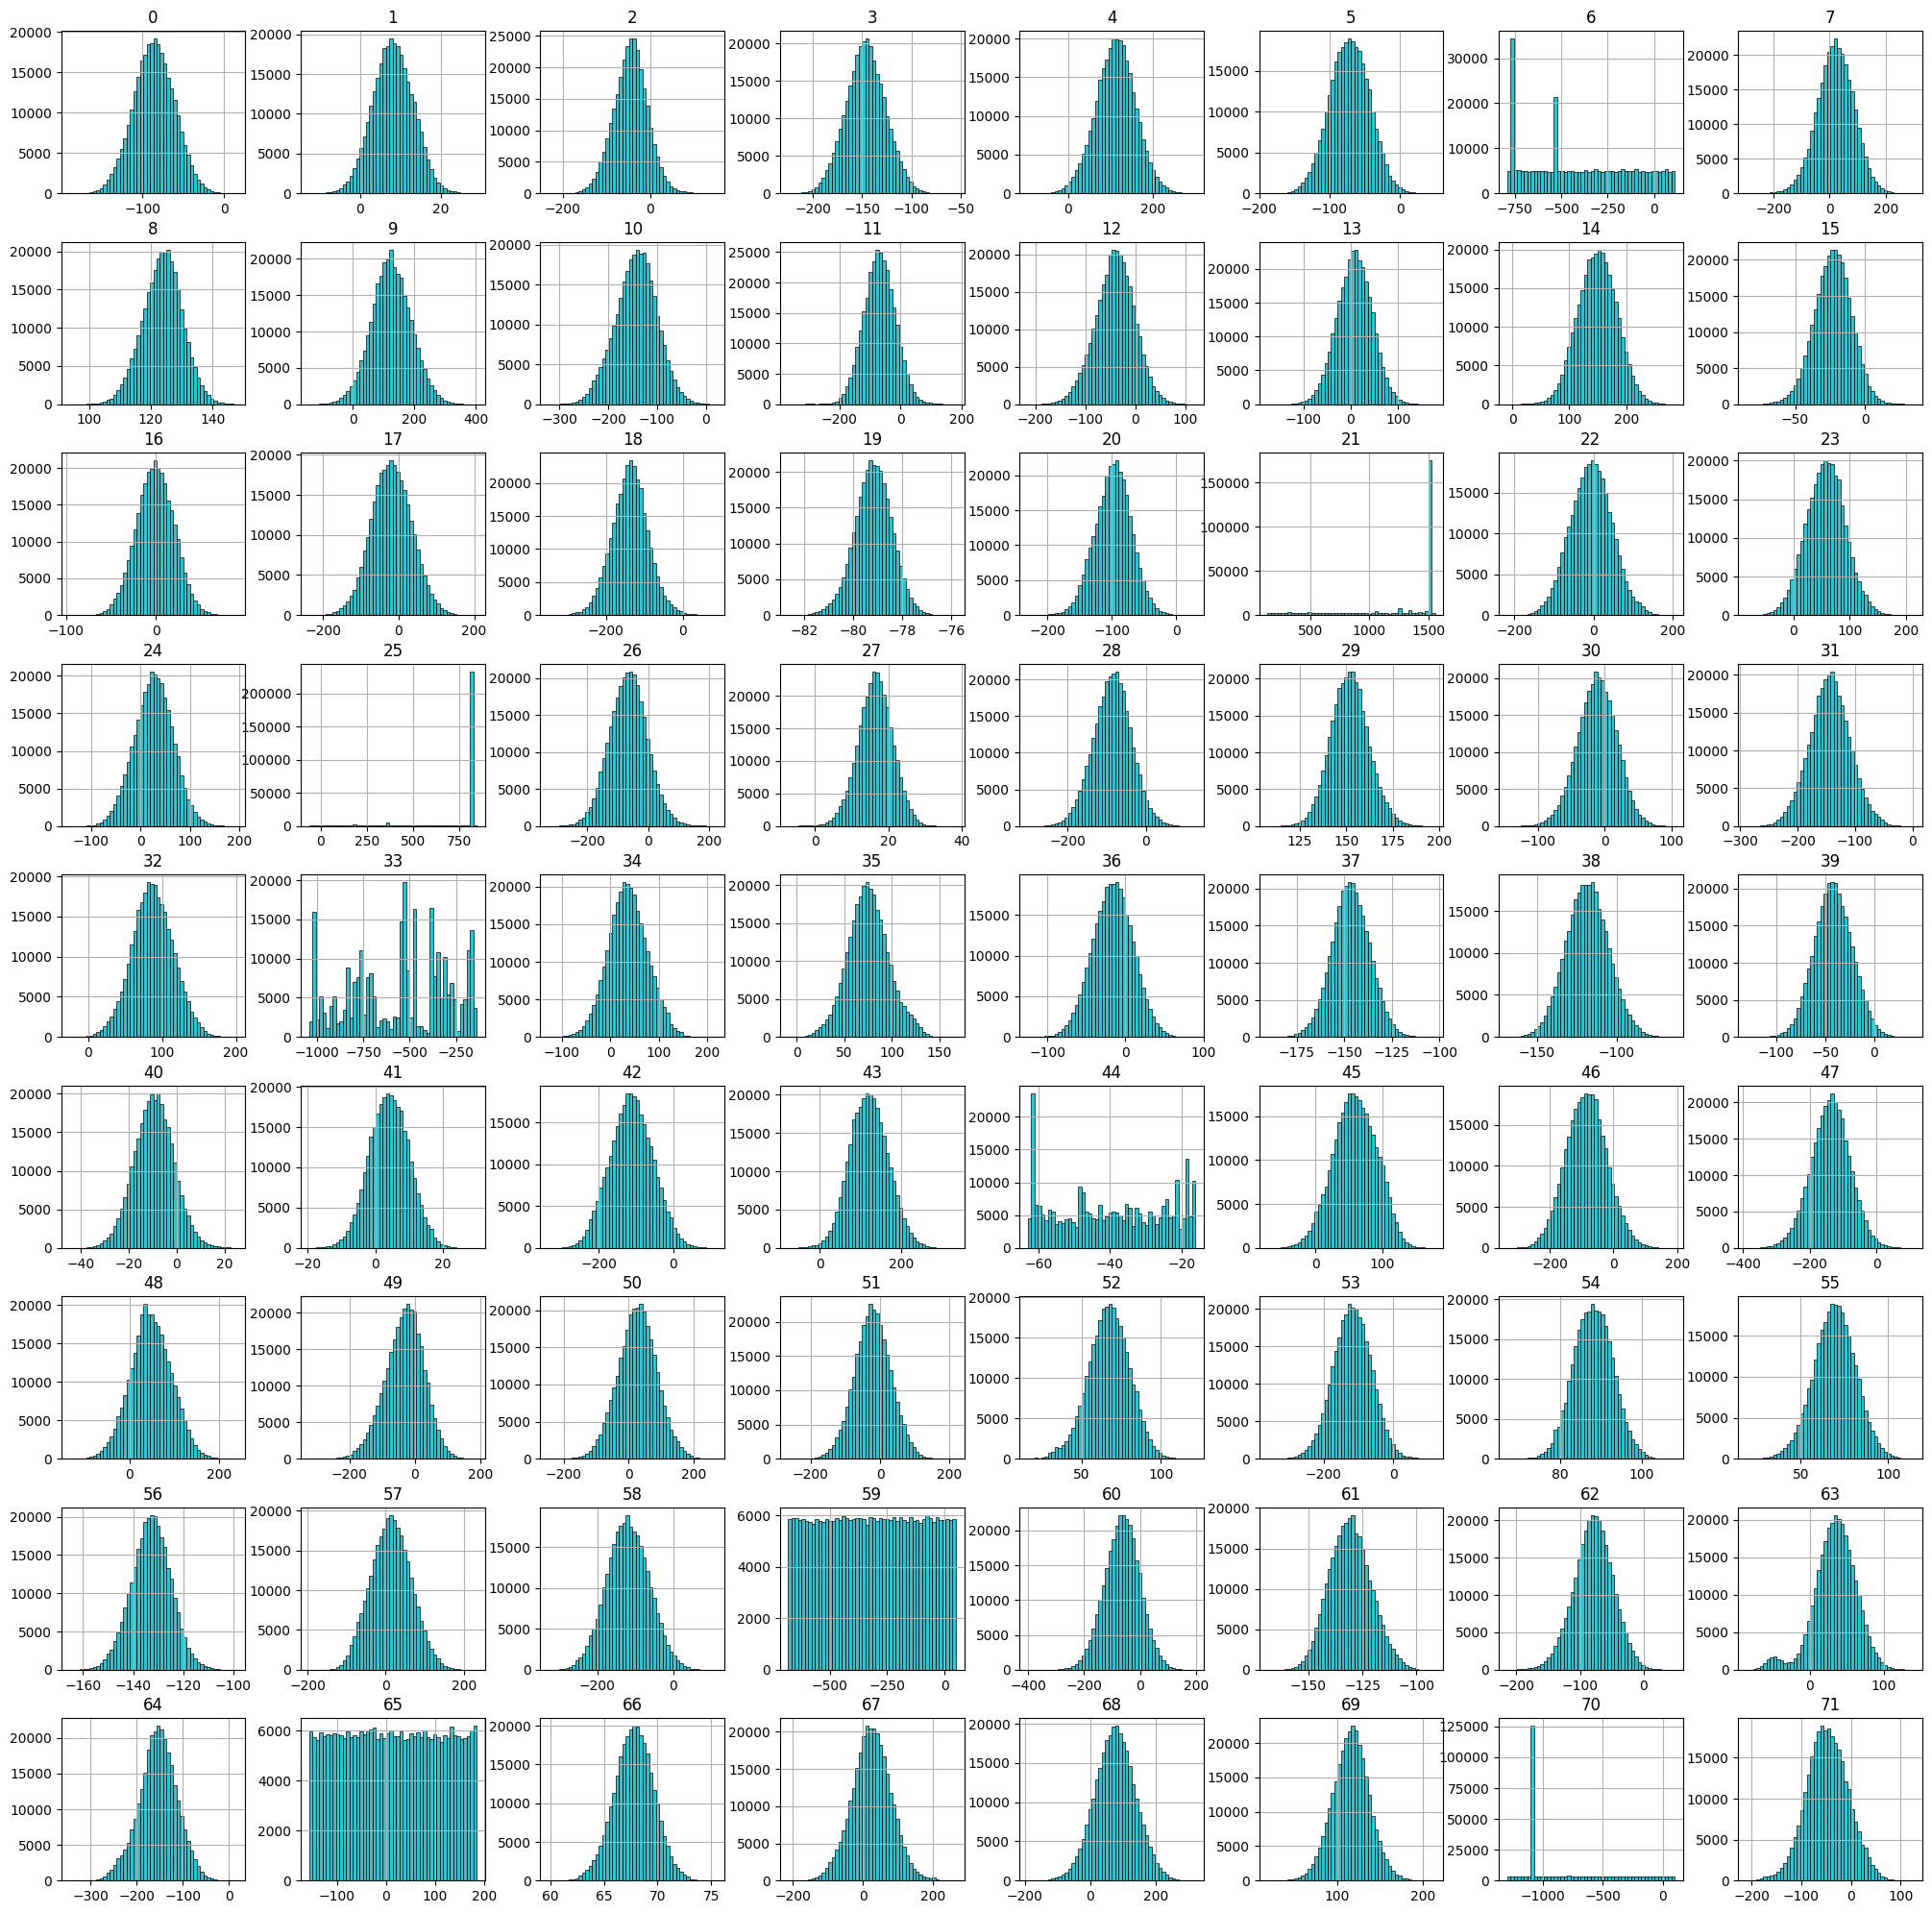

In [ ]:
df_base.hist(bins=50, figsize=(25,25), color='#35c0cd', edgecolor='black', linewidth=0.5)
plt.show()

Большинство признаков показывают нормальное или почти нормальное распределение данных.

На некоторых графиках (например, панели 21, 25, 44, 70) видны выбросы и аномалии.

Некоторые гистограммы, например панели  6, и 65, 69 показывают асимметричные распределения.

Проверим данные на корреляцию и мультиколлинеарность.

<div class="alert alert-block alert-success">

Ок, распределения проанализированы:) Ты верно отметила, что в некоторых признаках есть выбросы.
    
Подробнее про типы распределений можно посмотреть: https://machinelearningmastery.com/statistical-data-distributions/
   
</div>

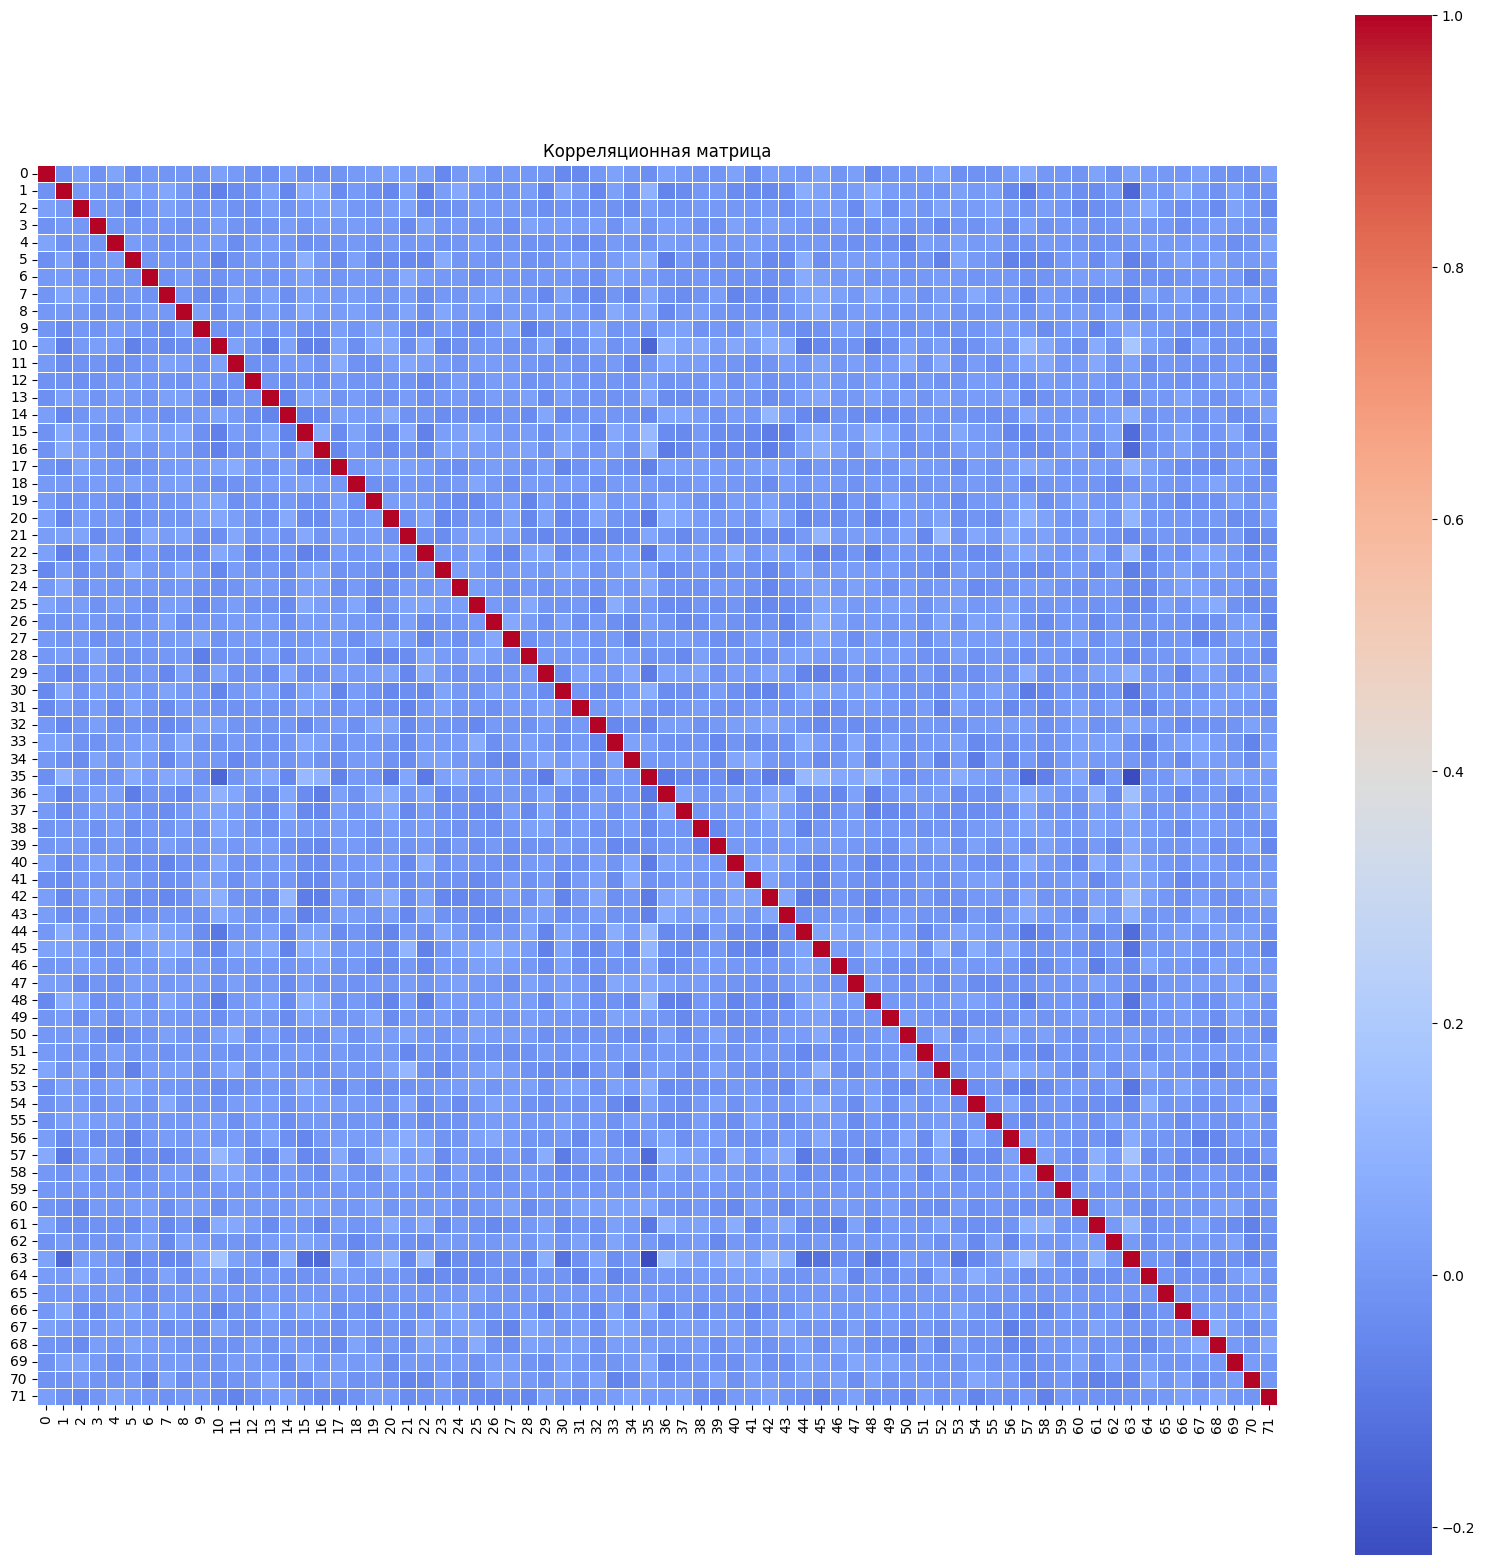

In [ ]:
corr_matrix = df_base.corr()

# Создание тепловой карты
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, fmt=".1f", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Корреляционная матрица')
plt.show 

Прищнаки в основном показывают очень низкие значения корреляции, близкие к нулю, что указывает на отсутствие значимой линейной зависимости между большинством переменных. Это хорошо потому что корреляция могла бы повлиять на результаты работы алгоритма.

Изредка на тепловой карте видны более темные или светлые точки, которые могут указывать на наличие слабой положительной или отрицательной корреляции между некоторыми переменными. Но их очень мало и они не образуют заметных групп или блоков, что говорит о том, что это разовые случаи, и закономерности нет.

Для каждого признака построим гистограмма+боксплот, чтобы подробнее изучить распределения и найти выбросы.

<div class="alert alert-block alert-success">

Ты верно отметила, что коэффициент корреляции Пиросна показывает только линейную связь между признаками, а в общем случае связь может быть и нелинейной.
    
Дополнительно можно посмотреть: https://habr.com/ru/companies/akbarsdigital/articles/592493/ и https://phik.readthedocs.io/en/latest/

При анализе корреляций можно ещё использовать библиотеку Phi_K, которая специально разработана для анализа корреляций (https://phik.readthedocs.io/en/latest/).
</div>

In [ ]:
def two_graf(data_train, name, bins):
    print()
    print('\033[1m' + f'Описание признака {name}:' + '\033[0m')
    print(data_train.describe())

    plt.suptitle(f'Распределение данных для признака {name}:')

    #Гистограмма
    plt.subplot(1, 2, 1)
    data_train.plot(
        kind='hist',
        bins=bins,
        grid=True,
        figsize = (5,4),
        color = '#35c0cd',
        edgecolor='black');
    plt.ylabel('')
    plt.xlabel(f'{name} train');

    #Боксплот
    plt.subplot(1, 2, 2)
    box = plt.boxplot(
        x=data_train, vert=True, widths=0.5,
        patch_artist=True,
        boxprops = dict(facecolor = "#35c0cd")
    )
    plt.show()

    z1 = data_train.quantile(0.25)
    z3 = data_train.quantile(0.75)
    r = z3 - z1
    lower = z1 - (1.5 * r)
    upper = z3 + (1.5 * r)
    print('\033[1m' + f'Пороговые значения признака {name}:' + '\033[0m')
    print('Нижняя граница значений:', lower.round(2))
    print('Верхняя граница значений:', upper.round(2))

<div class="alert alert-block alert-warning">

Рекомендую при написании кода придерживаться правил PEP8 и добавить документацию (docstrings) к функциям.

Подробнее:

https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
https://peps.python.org/pep-0257/
</div>


Описание признака 0:
count    291813.000000
mean        -86.274741
std          24.918947
min        -189.356020
25%        -103.154300
50%         -86.308130
75%         -69.254616
max          15.574616
Name: 0, dtype: float64


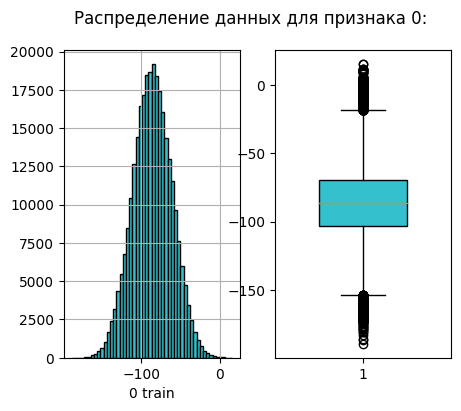

Пороговые значения признака 0:
Нижняя граница значений: -154.0
Верхняя граница значений: -18.41

Описание признака 1:
count    291813.000000
mean          8.078087
std           4.949495
min         -12.594500
25%           4.709408
50%           8.040010
75%          11.466815
max          28.751917
Name: 1, dtype: float64


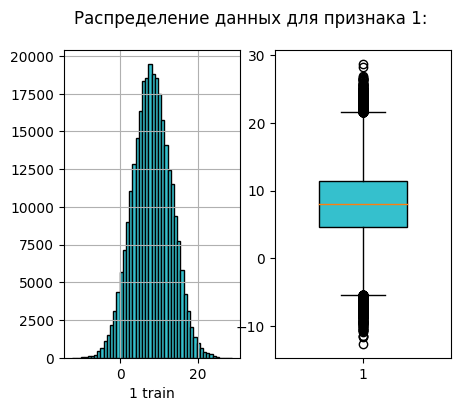

Пороговые значения признака 1:
Нижняя граница значений: -5.43
Верхняя граница значений: 21.6

Описание признака 2:
count    291813.000000
mean        -44.613480
std          38.545928
min        -231.785920
25%         -69.535900
50%         -43.838493
75%         -19.694052
max         151.377080
Name: 2, dtype: float64


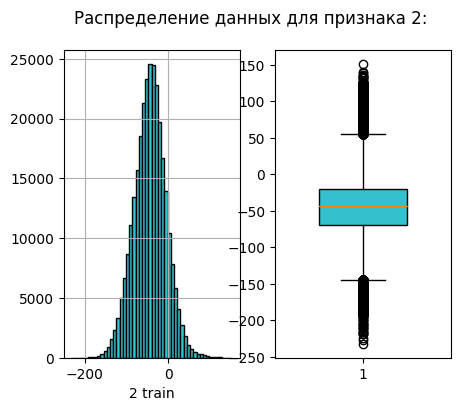

Пороговые значения признака 2:
Нижняя граница значений: -144.3
Верхняя граница значений: 55.07

Описание признака 3:
count    291813.000000
mean       -146.605552
std          19.842726
min        -224.880500
25%        -159.882740
50%        -146.717360
75%        -133.320140
max         -55.167892
Name: 3, dtype: float64


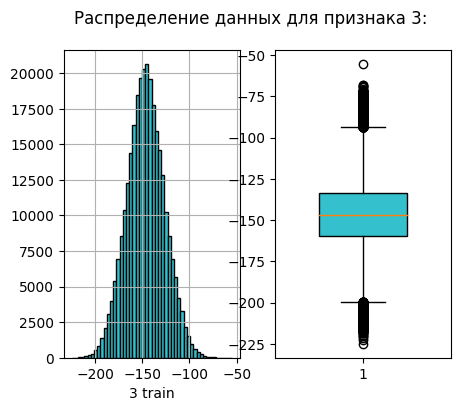

Пороговые значения признака 3:
Нижняя граница значений: -199.73
Верхняя граница значений: -93.48

Описание признака 4:
count    291813.000000
mean        111.261183
std          46.350083
min         -95.240830
25%          80.367640
50%         111.776870
75%         142.364610
max         299.307920
Name: 4, dtype: float64


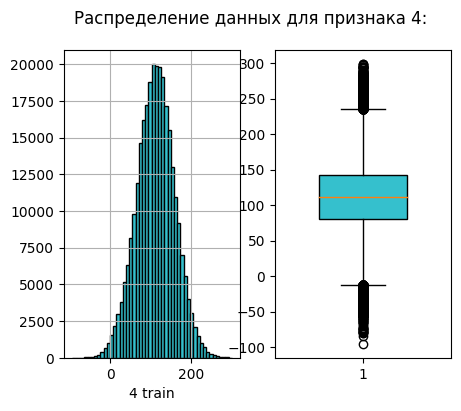

Пороговые значения признака 4:
Нижняя граница значений: -12.63
Верхняя граница значений: 235.36

Описание признака 5:
count    291813.000000
mean        -71.875015
std          28.189743
min        -188.473330
25%         -91.227936
50%         -71.751820
75%         -52.310825
max          49.880882
Name: 5, dtype: float64


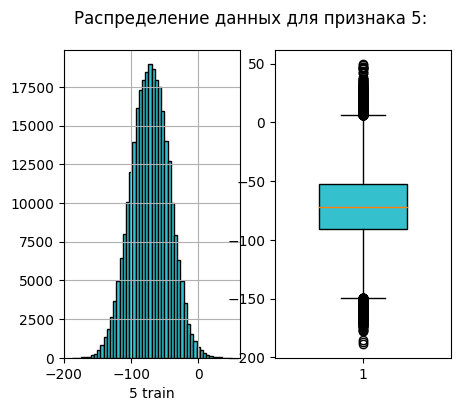

Пороговые значения признака 5:
Нижняя граница значений: -149.6
Верхняя граница значений: 6.06

Описание признака 6:
count    291813.000000
mean       -393.430460
std         272.084921
min        -791.468770
25%        -631.937855
50%        -424.306925
75%        -157.342700
max         109.631986
Name: 6, dtype: float64


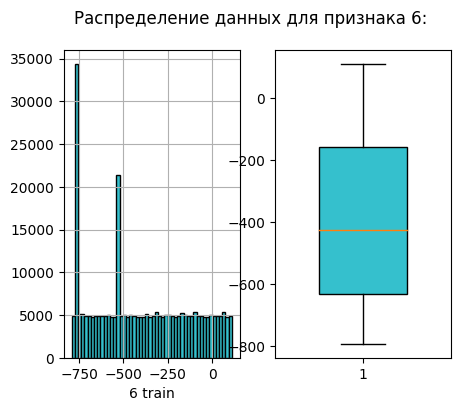

Пороговые значения признака 6:
Нижняя граница значений: -1343.83
Верхняя граница значений: 554.55

Описание признака 7:
count    291813.000000
mean         20.391975
std          64.297194
min        -296.171050
25%         -22.085905
50%          20.850153
75%          63.989326
max         301.094240
Name: 7, dtype: float64


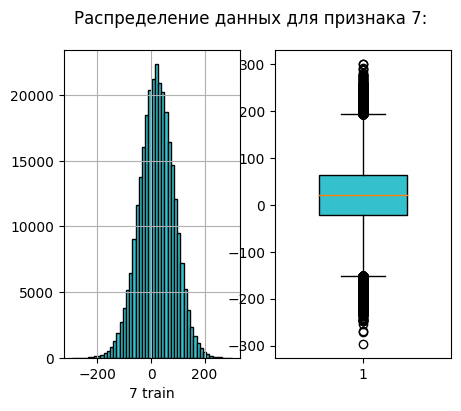

Пороговые значения признака 7:
Нижняя граница значений: -151.2
Верхняя граница значений: 193.1

Описание признака 8:
count    291813.000000
mean        123.676692
std           6.352832
min          93.684616
25%         119.473625
50%         123.882500
75%         127.967766
max         147.870910
Name: 8, dtype: float64


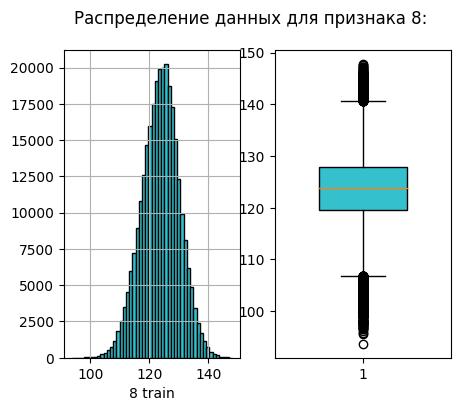

Пороговые значения признака 8:
Нижняя граница значений: 106.73
Верхняя граница значений: 140.71

Описание признака 9:
count    291813.000000
mean        124.427158
std          64.366631
min        -143.499600
25%          81.685610
50%         123.456270
75%         167.014130
max         402.994600
Name: 9, dtype: float64


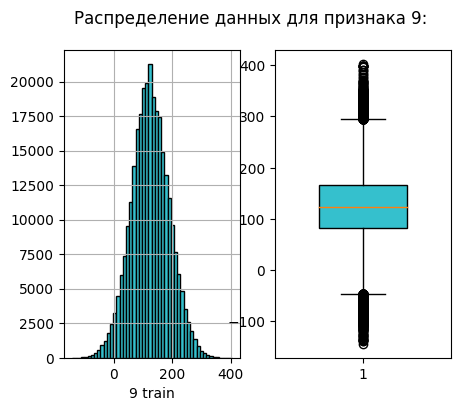

Пороговые значения признака 9:
Нижняя граница значений: -46.31
Верхняя граница значений: 295.01

Описание признака 10:
count    291813.000000
mean       -143.241671
std          41.828261
min        -321.522580
25%        -170.579130
50%        -141.831600
75%        -114.903490
max          20.790848
Name: 10, dtype: float64


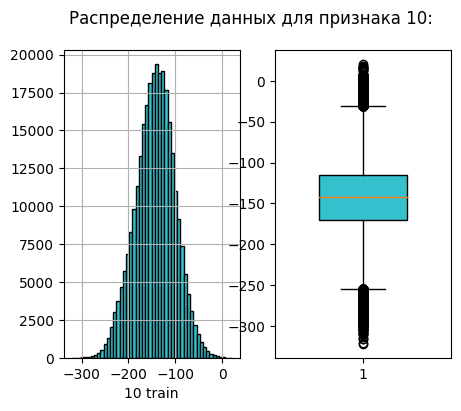

Пороговые значения признака 10:
Нижняя граница значений: -254.09
Верхняя граница значений: -31.39

Описание признака 11:
count    291813.000000
mean        -69.943874
std          51.194297
min        -367.130700
25%        -103.997734
50%         -70.376590
75%         -35.720950
max         180.045350
Name: 11, dtype: float64


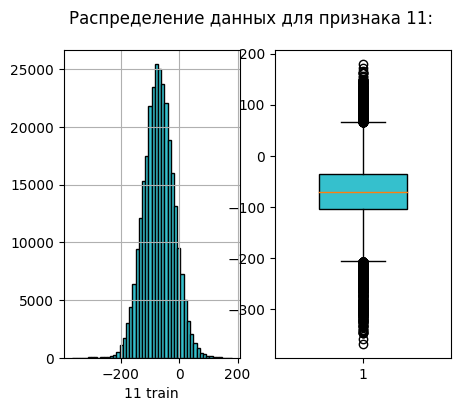

Пороговые значения признака 11:
Нижняя граница значений: -206.41
Верхняя граница значений: 66.69

Описание признака 12:
count    291813.000000
mean        -41.180997
std          38.942859
min        -215.223530
25%         -66.559790
50%         -40.306980
75%         -14.742321
max         119.991196
Name: 12, dtype: float64


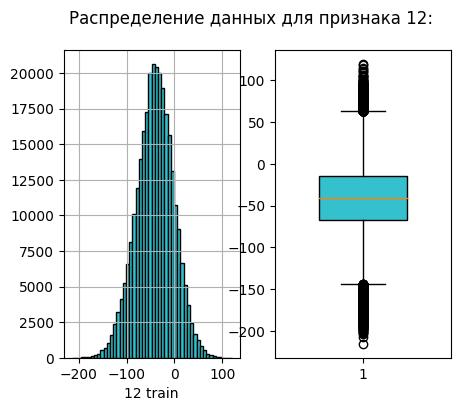

Пороговые значения признака 12:
Нижняя граница значений: -144.29
Верхняя граница значений: 62.98

Описание признака 13:
count    291813.000000
mean          7.608319
std          36.576025
min        -175.623890
25%         -16.890121
50%           8.157776
75%          32.713478
max         177.527040
Name: 13, dtype: float64


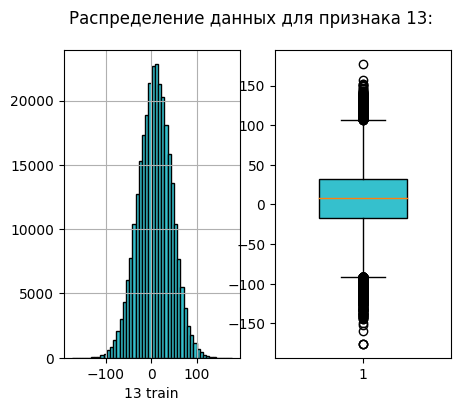

Пороговые значения признака 13:
Нижняя граница значений: -91.3
Верхняя граница значений: 107.12

Описание признака 14:
count    291813.000000
mean        148.940275
std          33.623142
min          -9.157745
25%         126.042564
50%         149.268500
75%         172.093140
max         284.657040
Name: 14, dtype: float64


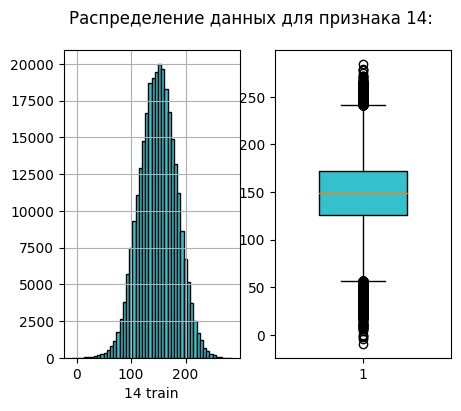

Пороговые значения признака 14:
Нижняя граница значений: 56.97
Верхняя граница значений: 241.17

Описание признака 15:
count    291813.000000
mean        -23.195314
std          13.078519
min         -84.724250
25%         -31.799664
50%         -22.943250
75%         -14.360533
max          35.080270
Name: 15, dtype: float64


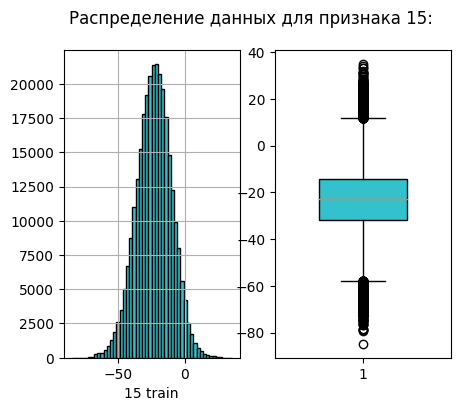

Пороговые значения признака 15:
Нижняя граница значений: -57.96
Верхняя граница значений: 11.8

Описание признака 16:
count    291813.000000
mean         -0.939536
std          20.826134
min         -96.368160
25%         -15.135077
50%          -1.027163
75%          13.355728
max          90.389210
Name: 16, dtype: float64


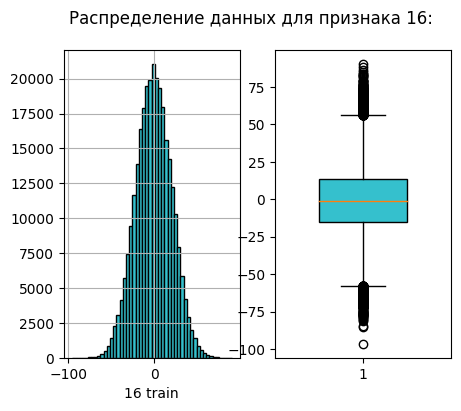

Пороговые значения признака 16:
Нижняя граница значений: -57.87
Верхняя граница значений: 56.09

Описание признака 17:
count    291813.000000
mean        -19.230876
std          52.952607
min        -237.018780
25%         -55.462906
50%         -19.778640
75%          16.777311
max         206.303970
Name: 17, dtype: float64


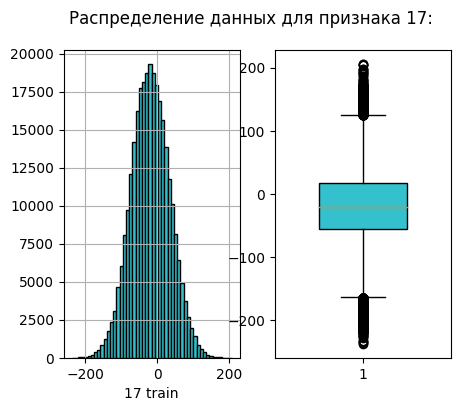

Пороговые значения признака 17:
Нижняя граница значений: -163.82
Верхняя граница значений: 125.14

Описание признака 18:
count    291813.000000
mean       -137.380758
std          46.676018
min        -348.336240
25%        -167.724230
50%        -136.877040
75%        -107.608000
max          86.998080
Name: 18, dtype: float64


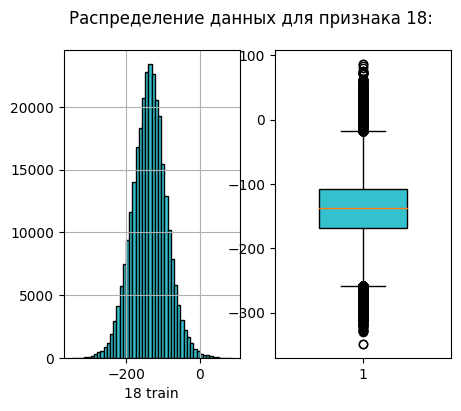

Пороговые значения признака 18:
Нижняя граница значений: -257.9
Верхняя граница значений: -17.43

Описание признака 19:
count    291813.000000
mean        -79.189608
std           0.757619
min         -82.659546
25%         -79.680220
50%         -79.179794
75%         -78.679110
max         -75.796460
Name: 19, dtype: float64


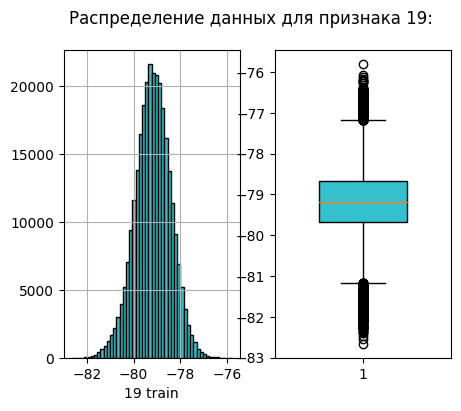

Пороговые значения признака 19:
Нижняя граница значений: -81.18
Верхняя граница значений: -77.18

Описание признака 20:
count    291813.000000
mean        -98.276602
std          28.155715
min        -230.840270
25%        -116.912186
50%         -97.536200
75%         -79.267240
max          30.247147
Name: 20, dtype: float64


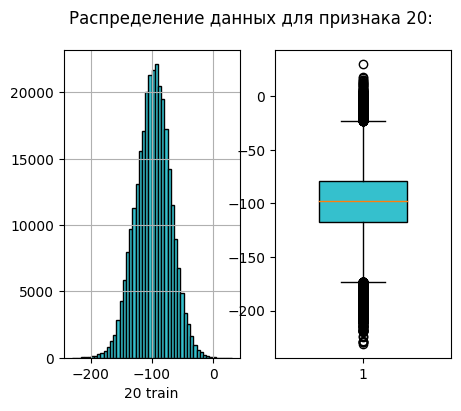

Пороговые значения признака 20:
Нижняя граница значений: -173.38
Верхняя граница значений: -22.8

Описание признака 21:
count    291813.000000
mean       1257.119646
std         400.140140
min         136.855507
25%        1086.240670
50%        1507.231274
75%        1507.231274
max        1557.418340
Name: 21, dtype: float64


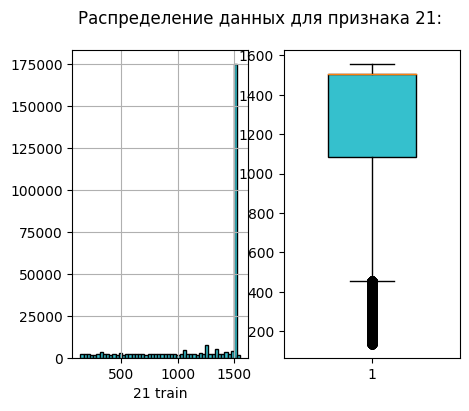

Пороговые значения признака 21:
Нижняя граница значений: 454.75
Верхняя граница значений: 2138.72

Описание признака 22:
count    291813.000000
mean         -6.817302
std          51.984937
min        -219.015870
25%         -42.276604
50%          -6.456830
75%          28.285309
max         204.201260
Name: 22, dtype: float64


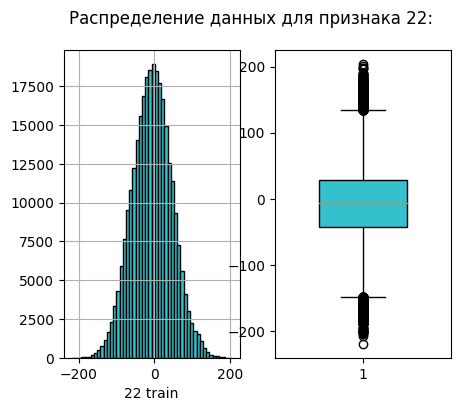

Пороговые значения признака 22:
Нижняя граница значений: -148.12
Верхняя граница значений: 134.13

Описание признака 23:
count    291813.000000
mean         56.737918
std          34.382587
min         -83.704820
25%          33.351940
50%          57.078365
75%          79.703354
max         214.311230
Name: 23, dtype: float64


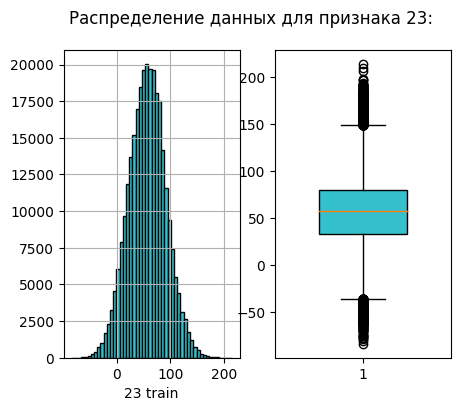

Пороговые значения признака 23:
Нижняя граница значений: -36.18
Верхняя граница значений: 149.23

Описание признака 24:
count    291813.000000
mean         26.645141
std          38.963153
min        -143.183290
25%           0.418633
50%          27.024698
75%          53.100124
max         195.515240
Name: 24, dtype: float64


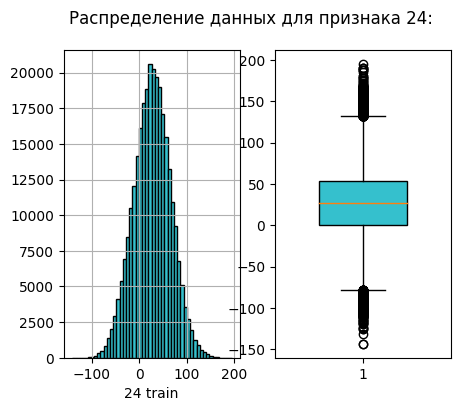

Пороговые значения признака 24:
Нижняя граница значений: -78.6
Верхняя граница значений: 132.12

Описание признака 25:
count    291813.000000
mean        726.539553
std         206.009752
min         -61.967366
25%         813.770071
50%         813.770071
75%         813.770071
max         845.758252
Name: 25, dtype: float64


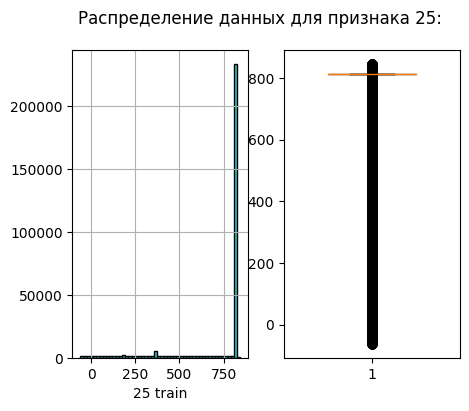

Пороговые значения признака 25:
Нижняя граница значений: 813.77
Верхняя граница значений: 813.77

Описание признака 26:
count    291813.000000
mean        -65.999767
std          61.551614
min        -327.226200
25%        -107.548615
50%         -65.847090
75%         -25.462177
max         222.614410
Name: 26, dtype: float64


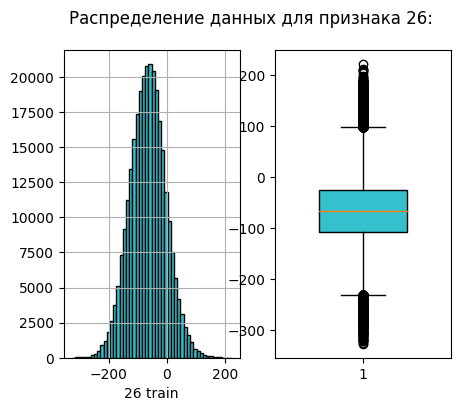

Пороговые значения признака 26:
Нижняя граница значений: -230.68
Верхняя граница значений: 97.67

Описание признака 27:
count    291813.000000
mean         16.297703
std           4.657027
min          -7.296732
25%          13.250520
50%          16.361536
75%          19.419718
max          38.266210
Name: 27, dtype: float64


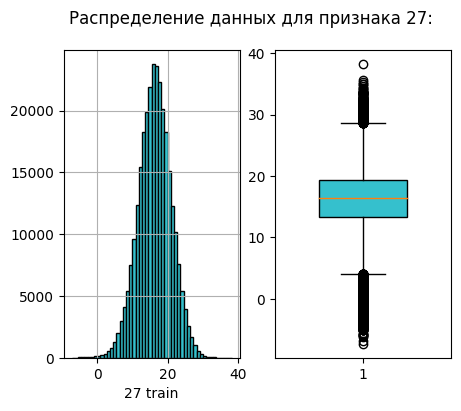

Пороговые значения признака 27:
Нижняя граница значений: 4.0
Верхняя граница значений: 28.67

Описание признака 28:
count    291813.000000
mean        -86.279764
std          48.329281
min        -302.772400
25%        -118.420650
50%         -85.432304
75%         -53.865955
max         127.499540
Name: 28, dtype: float64


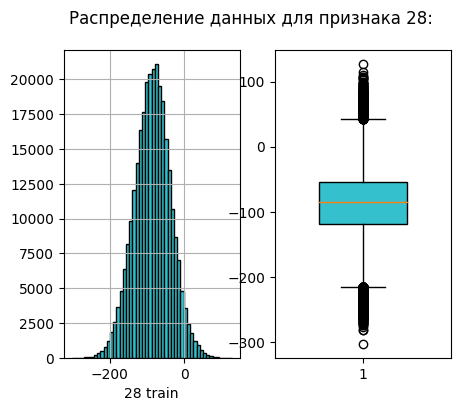

Пороговые значения признака 28:
Нижняя граница значений: -215.25
Верхняя граница значений: 42.97

Описание признака 29:
count    291813.000000
mean        151.737398
std          10.093783
min         107.650450
25%         144.899320
50%         151.636260
75%         158.272890
max         197.499940
Name: 29, dtype: float64


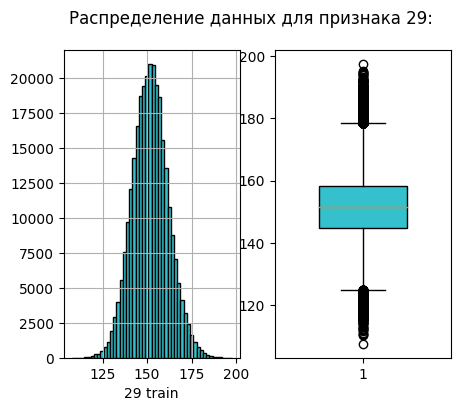

Пороговые значения признака 29:
Нижняя граница значений: 124.84
Верхняя граница значений: 178.33

Описание признака 30:
count    291813.000000
mean        -11.569343
std          28.934056
min        -146.495420
25%         -30.690517
50%         -11.121221
75%           8.277879
max         105.036690
Name: 30, dtype: float64


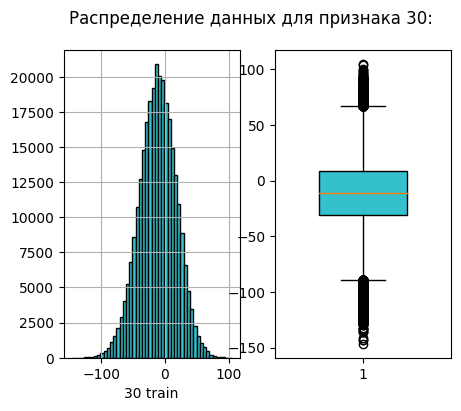

Пороговые значения признака 30:
Нижняя граница значений: -89.14
Верхняя граница значений: 66.73

Описание признака 31:
count    291813.000000
mean       -144.233906
std          34.905297
min        -288.613980
25%        -167.123320
50%        -144.202120
75%        -121.317720
max           2.917328
Name: 31, dtype: float64


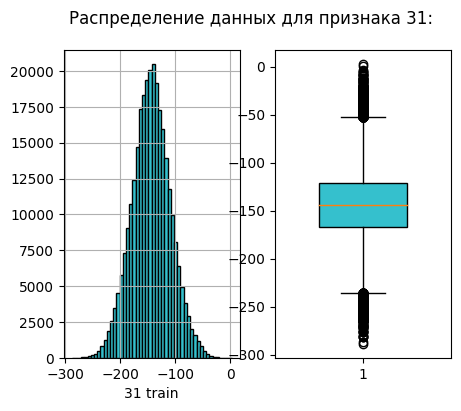

Пороговые значения признака 31:
Нижняя граница значений: -235.83
Верхняя граница значений: -52.61

Описание признака 32:
count    291813.000000
mean         87.271323
std          27.781245
min         -25.102974
25%          68.438130
50%          86.897890
75%         105.965280
max         201.428620
Name: 32, dtype: float64


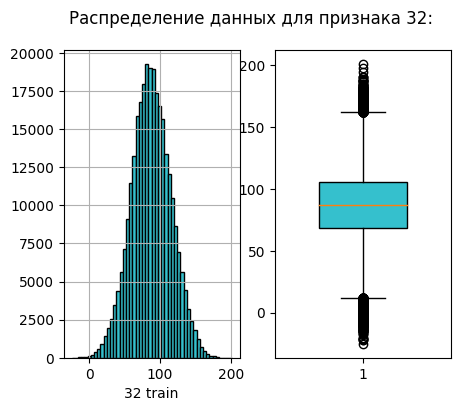

Пороговые значения признака 32:
Нижняя граница значений: 12.15
Верхняя граница значений: 162.26

Описание признака 33:
count    291813.000000
mean       -555.030333
std         260.728908
min       -1045.311529
25%        -771.296708
50%        -529.295053
75%        -341.781842
max        -137.646757
Name: 33, dtype: float64


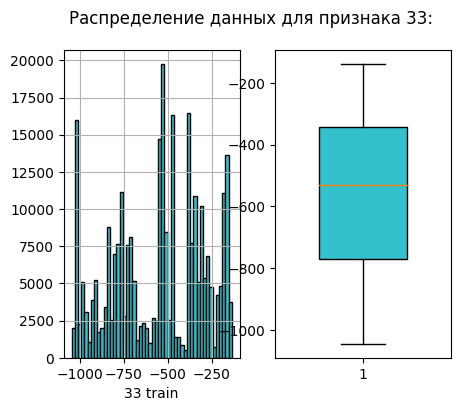

Пороговые значения признака 33:
Нижняя граница значений: -1415.57
Верхняя граница значений: 302.49

Описание признака 34:
count    291813.000000
mean         36.354556
std          39.894835
min        -126.765594
25%           9.454500
50%          35.477120
75%          62.989050
max         218.161000
Name: 34, dtype: float64


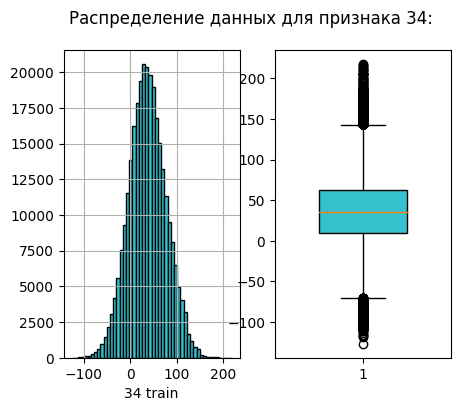

Пороговые значения признака 34:
Нижняя граница значений: -70.85
Верхняя граница значений: 143.29

Описание признака 35:
count    291813.000000
mean         75.165481
std          21.457381
min          -8.800842
25%          60.934887
50%          74.533540
75%          88.790180
max         166.948490
Name: 35, dtype: float64


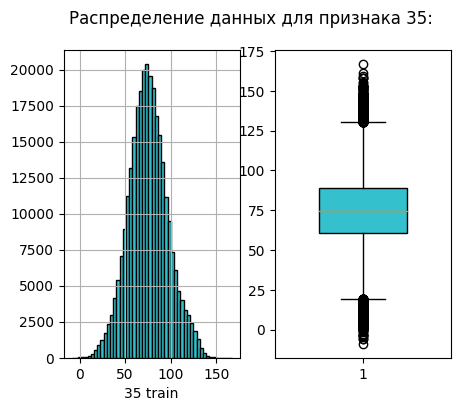

Пороговые значения признака 35:
Нижняя граница значений: 19.15
Верхняя граница значений: 130.57

Описание признака 36:
count    291813.000000
mean        -16.450743
std          25.832185
min        -125.226540
25%         -34.117690
50%         -16.169163
75%           1.232896
max          89.750755
Name: 36, dtype: float64


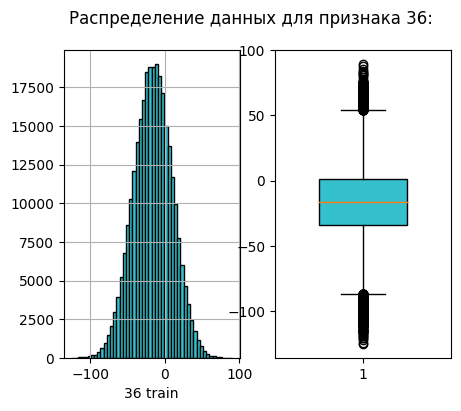

Пороговые значения признака 36:
Нижняя граница значений: -87.14
Верхняя граница значений: 54.26

Описание признака 37:
count    291813.000000
mean       -146.667125
std           9.952702
min        -190.385990
25%        -153.286560
50%        -146.750300
75%        -139.972290
max        -102.341890
Name: 37, dtype: float64


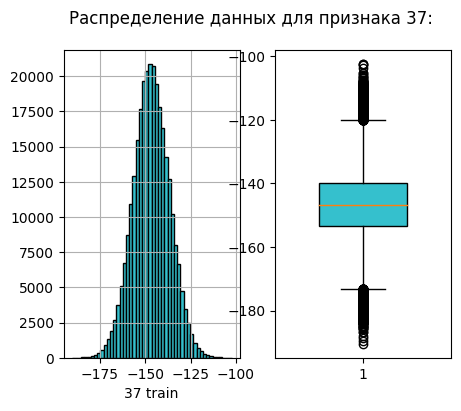

Пороговые значения признака 37:
Нижняя граница значений: -173.26
Верхняя граница значений: -120.0

Описание признака 38:
count    291813.000000
mean       -118.525117
std          13.125440
min        -168.637420
25%        -127.443540
50%        -118.587715
75%        -109.696080
max         -63.957638
Name: 38, dtype: float64


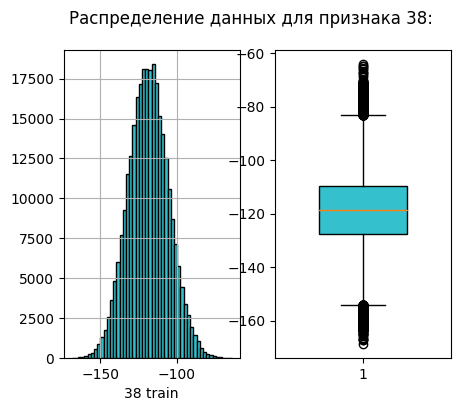

Пороговые значения признака 38:
Нижняя граница значений: -154.06
Верхняя граница значений: -83.07

Описание признака 39:
count    291813.000000
mean        -41.902869
std          19.208804
min        -130.044040
25%         -54.868080
50%         -42.066116
75%         -28.954714
max          40.955660
Name: 39, dtype: float64


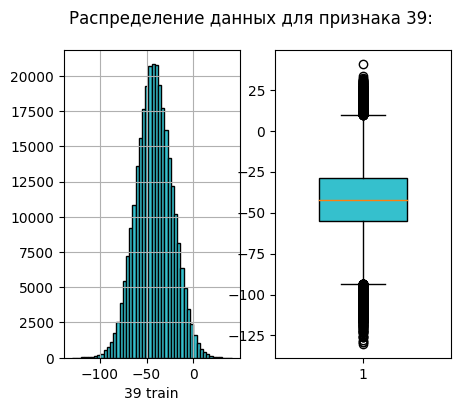

Пороговые значения признака 39:
Нижняя граница значений: -93.74
Верхняя граница значений: 9.92

Описание признака 40:
count    291813.000000
mean         -9.505951
std           8.188480
min         -44.640232
25%         -15.000622
50%          -9.496562
75%          -4.023318
max          25.123966
Name: 40, dtype: float64


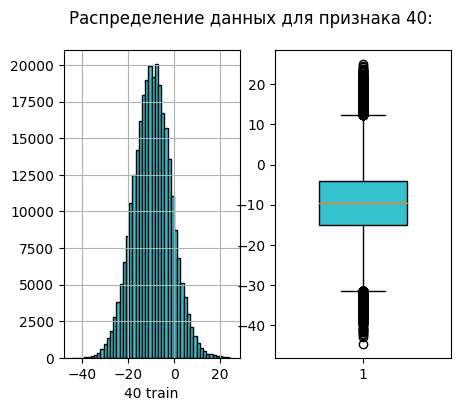

Пороговые значения признака 40:
Нижняя граница значений: -31.47
Верхняя граница значений: 12.44

Описание признака 41:
count    291813.000000
mean          4.069182
std           5.829764
min         -19.545673
25%           0.062776
50%           4.082789
75%           8.083019
max          29.969437
Name: 41, dtype: float64


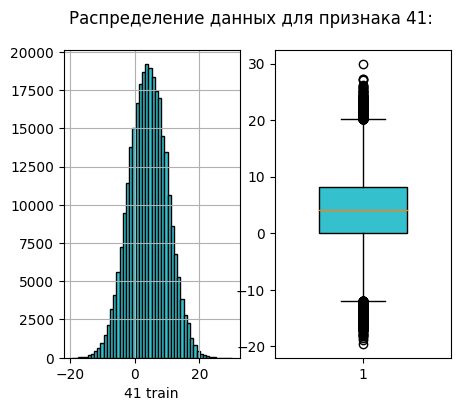

Пороговые значения признака 41:
Нижняя граница значений: -11.97
Верхняя граница значений: 20.11

Описание признака 42:
count    291813.000000
mean       -112.666843
std          56.950392
min        -335.376220
25%        -151.588910
50%        -112.994760
75%         -73.767555
max         116.259950
Name: 42, dtype: float64


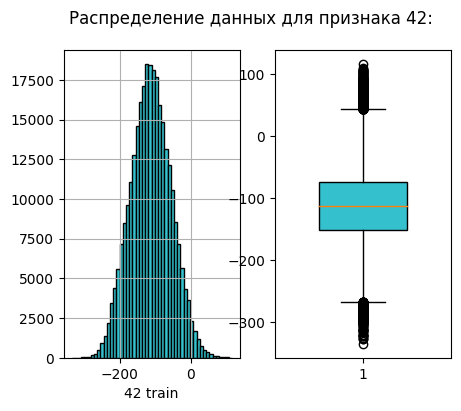

Пороговые значения признака 42:
Нижняя граница значений: -268.32
Верхняя граница значений: 42.96

Описание признака 43:
count    291813.000000
mean        120.820683
std          46.780878
min         -78.077320
25%          88.175010
50%         119.890175
75%         152.208130
max         335.198730
Name: 43, dtype: float64


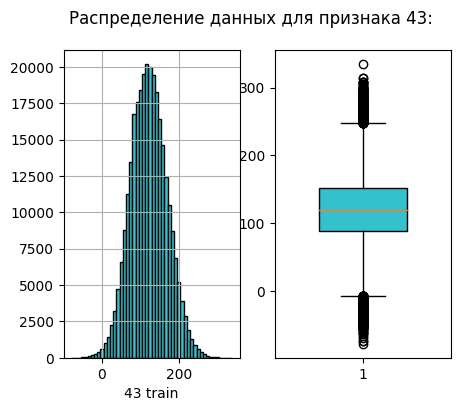

Пороговые значения признака 43:
Нижняя граница значений: -7.87
Верхняя граница значений: 248.26

Описание признака 44:
count    291813.000000
mean        -39.788570
std          14.735848
min         -63.102401
25%         -52.853639
50%         -39.989435
75%         -25.981533
max         -16.052626
Name: 44, dtype: float64


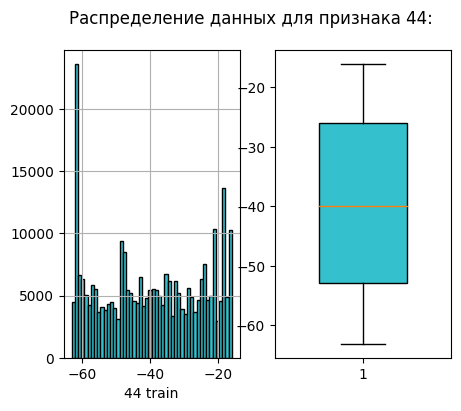

Пороговые значения признака 44:
Нижняя граница значений: -93.16
Верхняя граница значений: 14.33

Описание признака 45:
count    291813.000000
mean         58.962295
std          32.027228
min         -71.691635
25%          37.099083
50%          59.020420
75%          81.842316
max         178.599610
Name: 45, dtype: float64


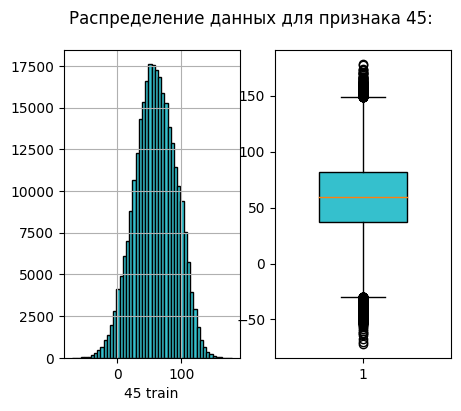

Пороговые значения признака 45:
Нижняя граница значений: -30.02
Верхняя граница значений: 148.96

Описание признака 46:
count    291813.000000
mean        -85.102851
std          63.265200
min        -334.213750
25%        -128.600830
50%         -85.374435
75%         -43.052475
max         191.472290
Name: 46, dtype: float64


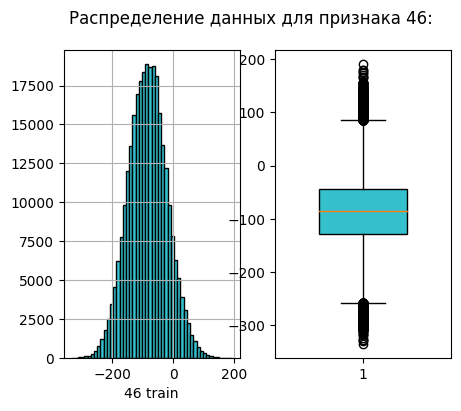

Пороговые значения признака 46:
Нижняя граница значений: -256.92
Верхняя граница значений: 85.27

Описание признака 47:
count    291813.000000
mean       -138.542656
std          57.718288
min        -389.026640
25%        -176.601260
50%        -137.508010
75%        -100.048490
max         112.636200
Name: 47, dtype: float64


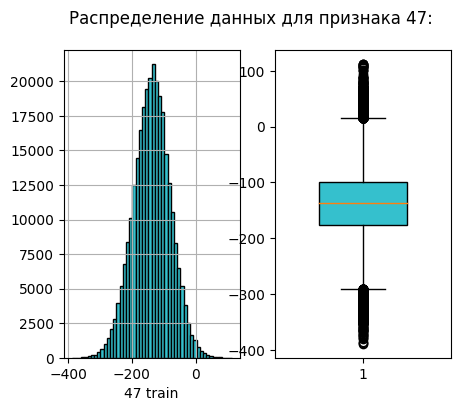

Пороговые значения признака 47:
Нижняя граница значений: -291.43
Верхняя граница значений: 14.78

Описание признака 48:
count    291813.000000
mean         47.962621
std          45.199092
min        -133.092030
25%          17.886696
50%          46.958180
75%          78.641650
max         239.683790
Name: 48, dtype: float64


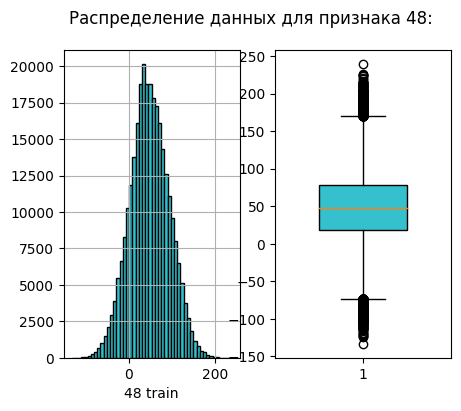

Пороговые значения признака 48:
Нижняя граница значений: -73.25
Верхняя граница значений: 169.77

Описание признака 49:
count    291813.000000
mean        -32.597303
std          58.254867
min        -322.812070
25%         -70.013220
50%         -29.367325
75%           7.430988
max         187.693790
Name: 49, dtype: float64


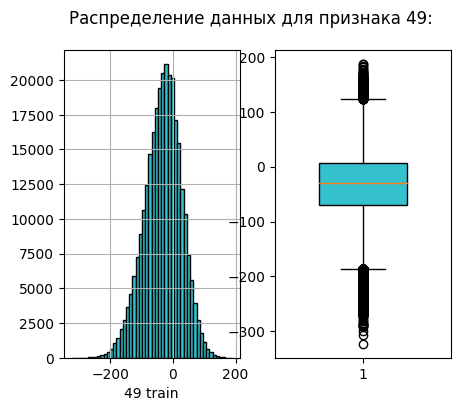

Пороговые значения признака 49:
Нижняя граница значений: -186.18
Верхняя граница значений: 123.6

Описание признака 50:
count    291813.000000
mean         26.591666
std          59.066918
min        -245.635030
25%         -12.432201
50%          27.534252
75%          66.127460
max         269.815220
Name: 50, dtype: float64


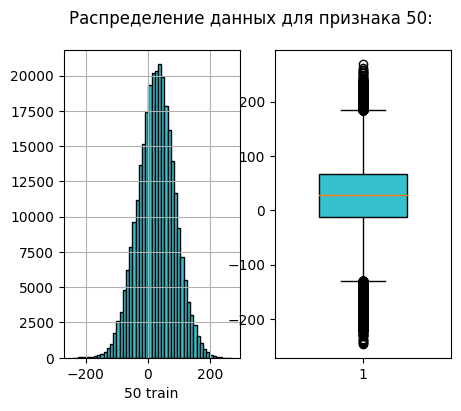

Пороговые значения признака 50:
Нижняя граница значений: -130.27
Верхняя граница значений: 183.97

Описание признака 51:
count    291813.000000
mean        -21.808728
std          51.778506
min        -264.633450
25%         -56.357270
50%         -22.228325
75%          12.686851
max         217.989270
Name: 51, dtype: float64


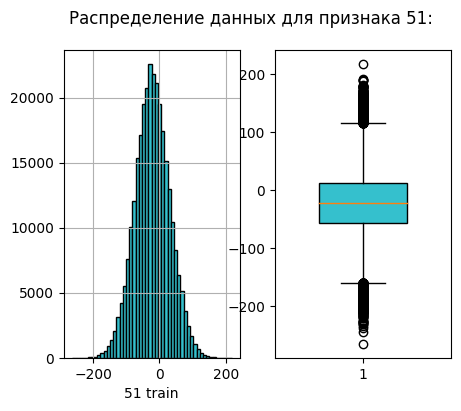

Пороговые значения признака 51:
Нижняя граница значений: -159.92
Верхняя граница значений: 116.25

Описание признака 52:
count    291813.000000
mean         67.033070
std          13.063570
min          16.126598
25%          58.475163
50%          67.248245
75%          75.949930
max         121.719666
Name: 52, dtype: float64


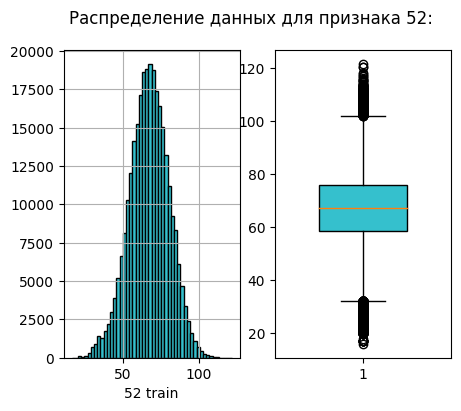

Пороговые значения признака 52:
Нижняя граница значений: 32.26
Верхняя граница значений: 102.16

Описание признака 53:
count    291813.000000
mean       -117.973309
std          54.774973
min        -361.489350
25%        -154.605010
50%        -117.657850
75%         -80.782550
max         120.150590
Name: 53, dtype: float64


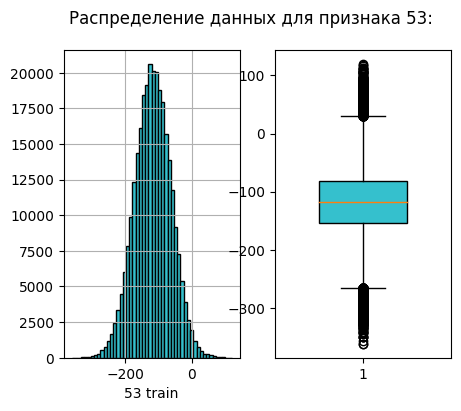

Пороговые значения признака 53:
Нижняя граница значений: -265.34
Верхняя граница значений: 29.95

Описание признака 54:
count    291813.000000
mean         88.033431
std           4.773332
min          66.851030
25%          84.714420
50%          88.016914
75%          91.311714
max         108.044174
Name: 54, dtype: float64


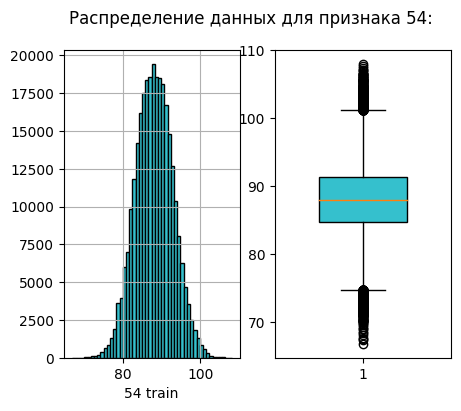

Пороговые значения признака 54:
Нижняя граница значений: 74.82
Верхняя граница значений: 101.21

Описание признака 55:
count    291813.000000
mean         69.206822
std          11.955396
min          18.996754
25%          61.307587
50%          69.343520
75%          77.262200
max         114.881516
Name: 55, dtype: float64


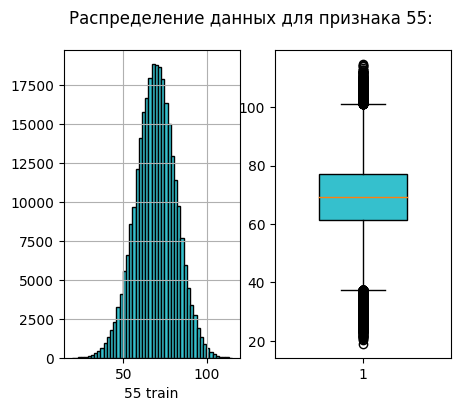

Пороговые значения признака 55:
Нижняя граница значений: 37.38
Верхняя граница значений: 101.19

Описание признака 56:
count    291813.000000
mean       -132.891610
std           7.820257
min        -165.421420
25%        -138.081620
50%        -132.809130
75%        -127.613100
max         -98.527270
Name: 56, dtype: float64


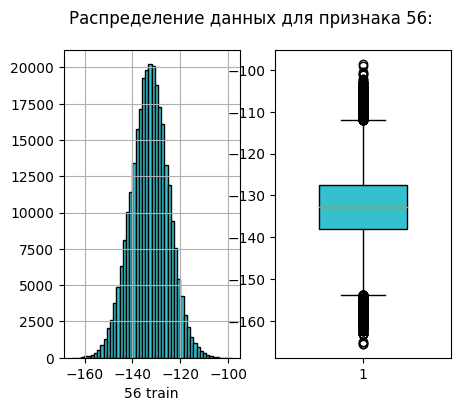

Пороговые значения признака 56:
Нижняя граница значений: -153.78
Верхняя граница значений: -111.91

Описание признака 57:
count    291813.000000
mean         13.104575
std          51.070116
min        -196.183610
25%         -22.556282
50%          13.010898
75%          48.060093
max         232.707750
Name: 57, dtype: float64


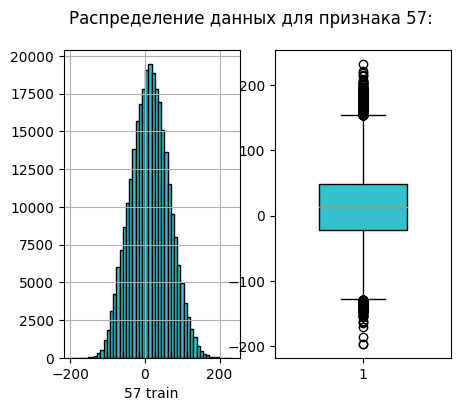

Пороговые значения признака 57:
Нижняя граница значений: -128.48
Верхняя граница значений: 153.98

Описание признака 58:
count    291813.000000
mean       -119.628076
std          55.163448
min        -328.829280
25%        -157.466060
50%        -120.447365
75%         -81.760864
max         113.967360
Name: 58, dtype: float64


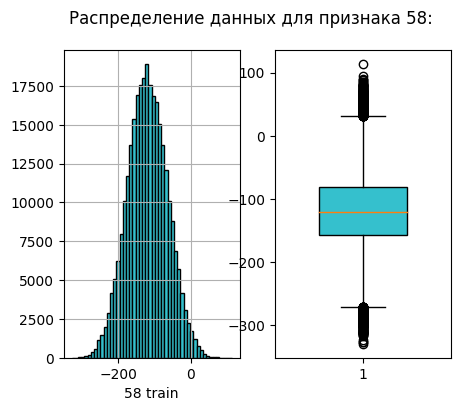

Пороговые значения признака 58:
Нижняя граница значений: -271.02
Верхняя граница значений: 31.8

Описание признака 59:
count    291813.000000
mean       -315.824414
std         210.631518
min        -681.042024
25%        -497.719259
50%        -315.599024
75%        -133.386267
max          48.727576
Name: 59, dtype: float64


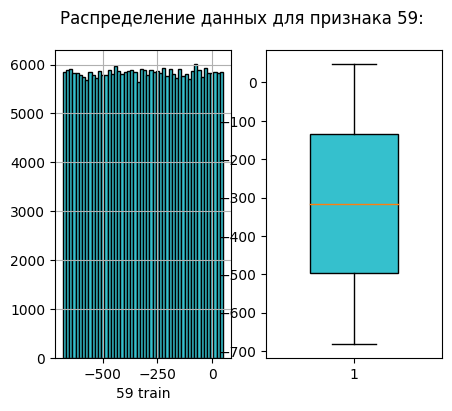

Пороговые значения признака 59:
Нижняя граница значений: -1044.22
Верхняя граница значений: 413.11

Описание признака 60:
count    291813.000000
mean        -64.894401
std          62.525113
min        -400.791100
25%        -106.710200
50%         -63.765030
75%         -22.567879
max         197.279700
Name: 60, dtype: float64


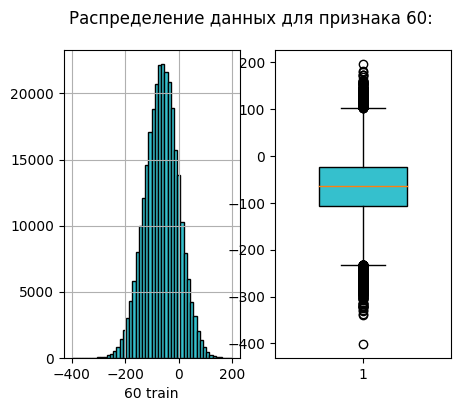

Пороговые значения признака 60:
Нижняя граница значений: -232.92
Верхняя граница значений: 103.65

Описание признака 61:
count    291813.000000
mean       -130.688468
std           9.573147
min        -169.028370
25%        -137.430160
50%        -130.912830
75%        -124.298180
max         -91.366425
Name: 61, dtype: float64


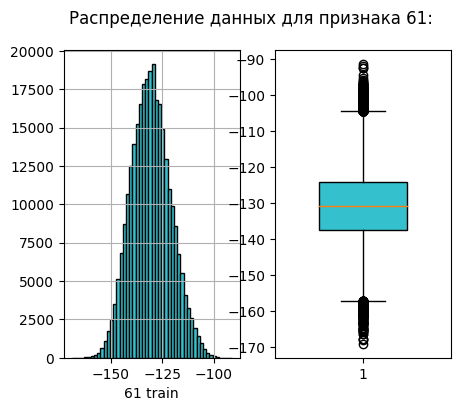

Пороговые значения признака 61:
Нижняя граница значений: -157.13
Верхняя граница значений: -104.6

Описание признака 62:
count    291813.000000
mean        -79.075207
std          30.485074
min        -214.821140
25%         -98.823830
50%         -78.538180
75%         -58.638412
max          48.822197
Name: 62, dtype: float64


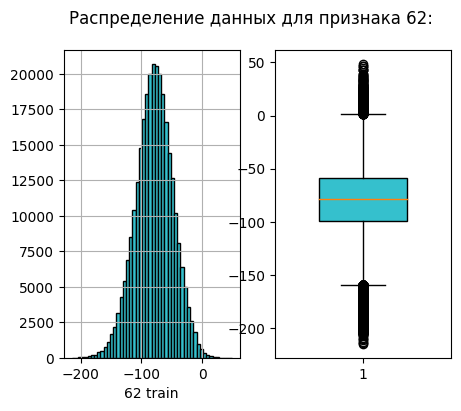

Пороговые значения признака 62:
Нижняя граница значений: -159.1
Верхняя граница значений: 1.64

Описание признака 63:
count    291813.000000
mean         33.244836
std          28.896144
min         -85.825500
25%          16.952824
50%          34.682540
75%          52.097710
max         141.025270
Name: 63, dtype: float64


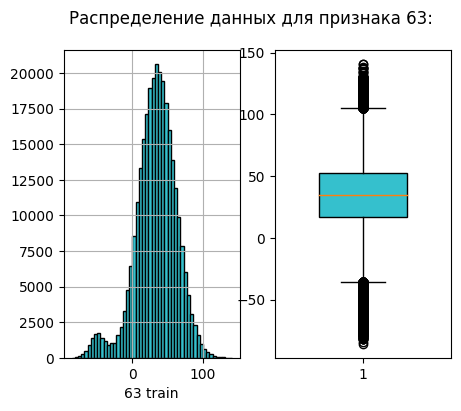

Пороговые значения признака 63:
Нижняя граница значений: -35.76
Верхняя граница значений: 104.82

Описание признака 64:
count    291813.000000
mean       -154.720293
std          41.217568
min        -346.239320
25%        -180.695560
50%        -153.902830
75%        -127.221360
max          17.344528
Name: 64, dtype: float64


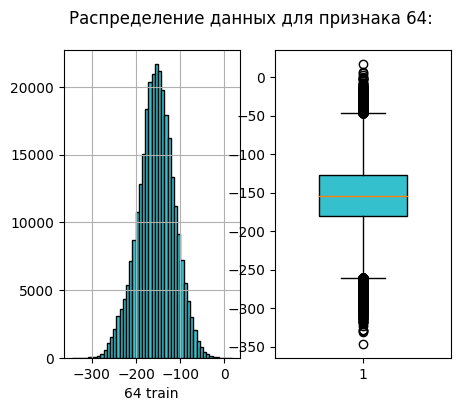

Пороговые значения признака 64:
Нижняя граница значений: -260.91
Верхняя граница значений: -47.01

Описание признака 65:
count    291813.000000
mean         13.699277
std          98.996416
min        -157.593866
25%         -71.763964
50%          13.167371
75%          99.362213
max         185.096719
Name: 65, dtype: float64


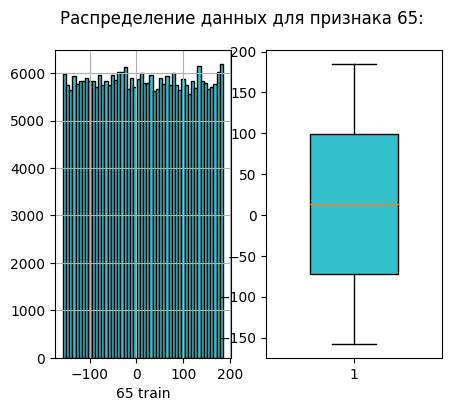

Пороговые значения признака 65:
Нижняя граница значений: -328.45
Верхняя граница значений: 356.05

Описание признака 66:
count    291813.000000
mean         67.792659
std           1.825081
min          59.835790
25%          66.582790
50%          67.815050
75%          69.028800
max          75.474625
Name: 66, dtype: float64


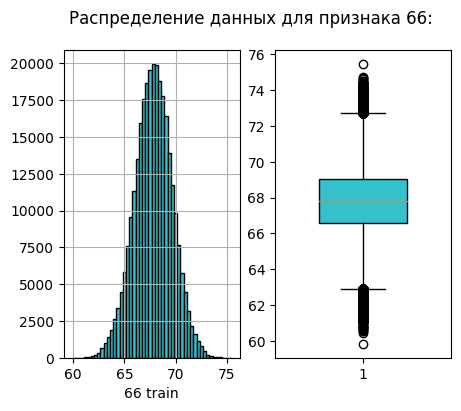

Пороговые значения признака 66:
Нижняя граница значений: 62.91
Верхняя граница значений: 72.7

Описание признака 67:
count    291813.000000
mean         23.543147
std          55.353032
min        -213.492420
25%         -12.501141
50%          23.461630
75%          59.740337
max         264.347200
Name: 67, dtype: float64


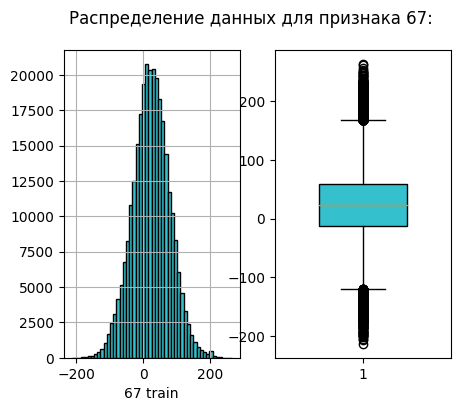

Пороговые значения признака 67:
Нижняя граница значений: -120.86
Верхняя граница значений: 168.1

Описание признака 68:
count    291813.000000
mean         74.890028
std          61.320347
min        -190.483150
25%          33.784820
50%          74.876980
75%         115.896880
max         319.601040
Name: 68, dtype: float64


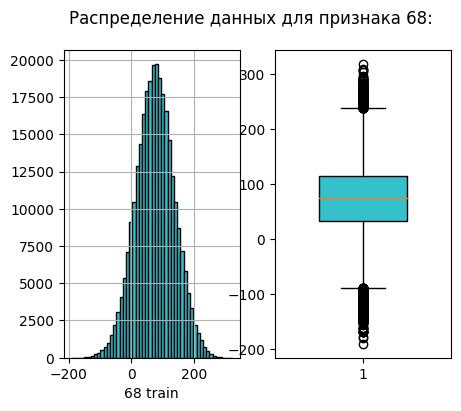

Пороговые значения признака 68:
Нижняя граница значений: -89.38
Верхняя граница значений: 239.06

Описание признака 69:
count    291813.000000
mean        115.611366
std          21.219222
min          18.601448
25%         101.675660
50%         116.049270
75%         129.625950
max         213.577260
Name: 69, dtype: float64


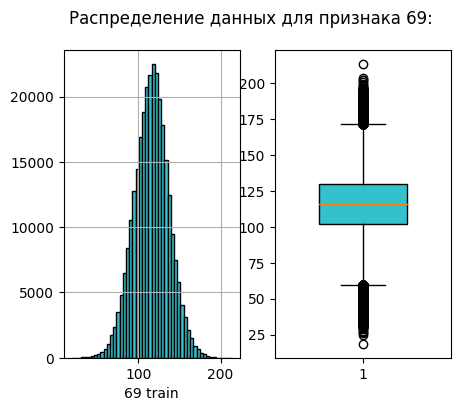

Пороговые значения признака 69:
Нижняя граница значений: 59.75
Верхняя граница значений: 171.55

Описание признака 70:
count    291813.000000
mean       -798.355219
std         385.414338
min       -1297.924962
25%       -1074.464888
50%       -1074.464888
75%        -504.291183
max          98.770811
Name: 70, dtype: float64


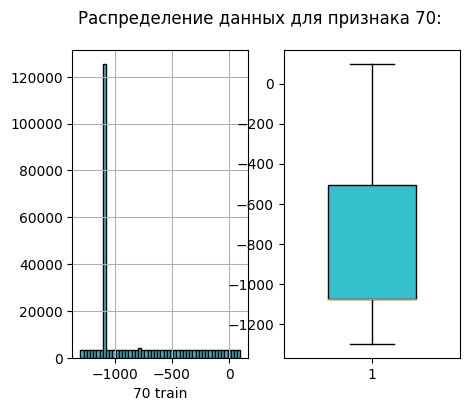

Пороговые значения признака 70:
Нижняя граница значений: -1929.73
Верхняя граница значений: 350.97

Описание признака 71:
count    291813.000000
mean        -47.701336
std          41.731025
min        -209.935760
25%         -75.621110
50%         -48.403816
75%         -19.684170
max         126.973220
Name: 71, dtype: float64


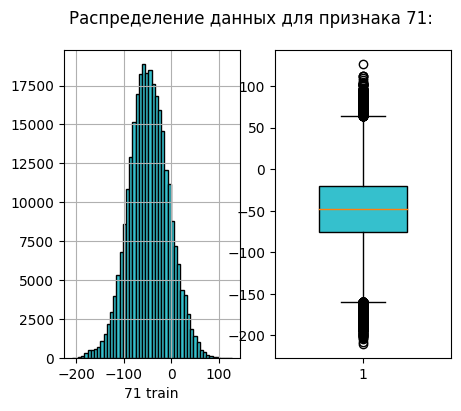

Пороговые значения признака 71:
Нижняя граница значений: -159.53
Верхняя граница значений: 64.22


In [ ]:
for j in df_base:
    two_graf(df_base[j], j, 50)

Признаки с ненормальным распределением данных:
* Признак 6 - однородное распределение с двумя пиками.
* Признаки 21 и 25 - однородное распределение с одним очень высоким пиком.
* Признак 33 - распределение с множеством пиков разных по высоте.
* Признак 44 - однородное распределение с пиками справа и слева.
* Признаки 59 и 65 - однородное распределение.
* Признак 70 - однородное распределение с одним высоким пиком.

Большая часть признаков с нормальным распределелнием и выбросами.

Проверим данные на мультиколлинеарность.


<div class="alert alert-block alert-success">

Отлично, распределения признаков проанализированы, но нужно ещё отметить есть ли выбросы в данных.
    
Дополнительные материалы по “ящикам с усами”: https://builtin.com/data-science/boxplot
</div>

In [ ]:
df = df_base[:5000]
X_variables = df_base[:5000]

vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

vif_data.sort_values(by='VIF', ascending=False).head(25)

,feature,VIF
19,19,2881.800277
66,66,1348.384102
8,8,394.847864
54,54,343.637480
56,56,298.053565
29,29,237.530472
37,37,227.162775
61,61,208.082127
38,38,84.612423
3,3,57.566087


Значения VIF выше 5 считются высокими. У нас в данных почти половина признаков с высоким VIF. Это может влиять на работу алгоритма мэтчинга.

Изучим важность признаков с помощью алгоритма случаного леса.

In [ ]:
base_targets = df_base.reset_index()
base_targets = base_targets.rename(columns={'Id': 'Target'})
base_targets = base_targets['Target']
base_targets = base_targets[:2000]
mini_base = df_base[:2000]
base_targets

0       4207931-base
1       2710972-base
2       1371460-base
3       3438601-base
4        422798-base
            ...     
1995    2983888-base
1996    4661708-base
1997     986723-base
1998    3828407-base
1999    1745635-base
Name: Target, Length: 2000, dtype: object

In [ ]:
train_targets = df_train["Target"]
train_features = df_train.drop("Target", axis=1)
train_targets = train_targets[:500]
train_features = train_features[:500]

In [ ]:
columns= mini_base.columns.values.tolist ()

In [ ]:
scaler = RobustScaler()

<div class="alert alert-block alert-success">

Использование RobustScaler это подходящий вариант, так как эта модель устойчива к выбросам в данных.
</div>

In [ ]:
base_features = pd.DataFrame(scaler.fit_transform(mini_base), columns=columns)
train_features = pd.DataFrame(scaler.fit_transform(train_features))

In [ ]:
clf=RandomForestClassifier(n_estimators=80, random_state=12345)
clf.fit(base_features,base_targets)

NameError: name 'base_features' is not defined

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,
                         base_features.columns)
feature_imp = feature_imp.sort_values()

In [ ]:
plt.subplots(figsize=(15, 20))
sns.barplot(x=feature_imp, y=feature_imp.index, color = '#35c0cd')
plt.xlabel('Важность признака')
plt.ylabel('Номер признака')
plt.title('Оценка важности признаков')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Признаки 21, 25, 33, 70 менее важны чем остальные, попробуем их удалить и посмотрим как скорость вычислений.

###Вывод после изучения данных

Данные без пропусков, с дубликатами, много мультиколлинеарных признаков, почти все признаки с нормальным распределением, но с выбросами. Нескоько признаков с равномерным распределением и аномалными значениями.

Такие шаги предлагаю для предобработки:

* Удаление дубликатов
* Удаление признаков с высокой мультиколлинеарностью.
* Работа с признаками, у которых нет нормального распределения.
* Удаление менее важных признаков.
* Масштабирование признаков.

##Предобработка данных

###Удаление дубликатов


In [ ]:
df_base_no_dubl = df_base.drop_duplicates()
df_train_no_dubl = df_train.drop_duplicates()
print("Дубликатов нет." if not df_base_no_dubl.duplicated().any() else "В данных есть дубликаты.")
print("Дубликатов нет." if not df_train_no_dubl.duplicated().any() else "В данных есть дубликаты.")

Дубликатов нет.
Дубликатов нет.


<div class="alert alert-block alert-success">

Да, дубликатов в данных нет)
</div>

###Подготовка выборок

In [ ]:
targets_train = df_train_no_dubl["Target"]
df_train_no_dubl.drop("Target", axis=1, inplace=True)
df_train_no_dubl.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.90313,-759.626065,-75.284454,120.55149,131.13170,-149.21106,-102.31221,21.387623,11.277594,143.22140,-22.01157,-3.618249,-16.005480,-133.38228,-78.89356,-65.690530,407.773575,-11.660624,67.00815,24.975033,813.770071,40.051064,17.933155,-75.435745,149.81720,-23.413877,-178.09557,133.78647,-906.571061,113.35556,83.942260,-16.592659,-146.52074,-120.237860,-27.341612,-8.845615,1.027612,-175.64772,167.73582,-32.931559,47.860960,-196.24750,-118.81005,-4.762772,-114.877680,37.397278,-55.616966,56.627056,-108.43317,87.372560,76.51343,-136.27057,3.652915,-164.57451,-635.284275,-75.647255,-116.679340,-41.234684,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750
34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.59761,-55.720337,130.059250,129.38335,76.20288,-137.79942,33.30165,-2.868191,-34.318770,189.06479,-19.33755,-14.208210,-71.110245,-157.74814,-78.70069,-91.741875,1054.205600,-41.845630,102.12862,72.559050,813.770071,-37.957787,17.598982,-159.975400,140.02528,-8.819328,-147.05518,113.81987,-529.295053,70.67494,55.976795,8.817799,-134.14812,-73.679794,-57.566544,-4.338496,-3.270682,-144.49920,144.65020,-37.903276,58.913525,-105.36284,-125.66783,19.367283,-29.087658,-35.021350,26.627962,55.718437,-110.52611,83.513374,75.92613,-135.68242,-7.429803,-180.64502,11.470171,16.464691,-121.807236,-90.814450,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705


<div class="alert alert-block alert-success">

Ок, разделение данных на фичи и таргет выполнено 👍👍👍
</div>

In [ ]:
df_base_no_dubl_1 = scaler.fit_transform(df_base_no_dubl)
df_train_no_dubl_1 = scaler.fit_transform(df_train_no_dubl)

In [ ]:
dims_no_dubl = df_base_no_dubl_1.shape[1]
quantizer_no_dubl = faiss.IndexFlatL2(dims_no_dubl)
idx_l2 = faiss.IndexIVFFlat(quantizer_no_dubl, dims_no_dubl, n_cells)

In [ ]:
base_index = {k: v for k, v in enumerate(df_base_no_dubl.index.to_list())}

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_no_dubl_1).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_no_dubl_1).astype('float32'))

CPU times: user 466 ms, sys: 117 ms, total: 582 ms
Wall time: 439 ms


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_no_dubl_1).astype('float32'), candidate_number)

CPU times: user 13.2 s, sys: 27.7 ms, total: 13.3 s
Wall time: 9.09 s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 45.5%


После удаления дубликатов и масштабирования признаков метрика сразу сильно выросла с 11 до 45 %. Продолжим работать с сокращенным датасетом без дубликатов.

<div class="alert alert-block alert-success">

Отличный прирост метрики 👍👍👍
</div>

###1. Удаление признаков, которые показали низкую важность и ненормальное распределение

Признаки 21, 25, 33, 70 стоят на последнем месте по важности признаков, удалим их и посмотрим на метрику.

In [ ]:
df_base_del = df_base_no_dubl.drop(['25', '21', '33', '70'], axis=1)
df_train_del = df_train_no_dubl.drop(['25', '21', '33', '70'], axis=1)

In [ ]:
df_base_del.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280535 entries, 4207931-base to 274130-base
Data columns (total 68 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       280535 non-null  float64
 1   1       280535 non-null  float64
 2   2       280535 non-null  float64
 3   3       280535 non-null  float64
 4   4       280535 non-null  float64
 5   5       280535 non-null  float64
 6   6       280535 non-null  float64
 7   7       280535 non-null  float64
 8   8       280535 non-null  float64
 9   9       280535 non-null  float64
 10  10      280535 non-null  float64
 11  11      280535 non-null  float64
 12  12      280535 non-null  float64
 13  13      280535 non-null  float64
 14  14      280535 non-null  float64
 15  15      280535 non-null  float64
 16  16      280535 non-null  float64
 17  17      280535 non-null  float64
 18  18      280535 non-null  float64
 19  19      280535 non-null  float64
 20  20      280535 non-null  float64
 21 

In [ ]:
#масштабирование признаков
df_base_del_scaler = scaler.fit_transform(df_base_del)
df_train_del_scaler = scaler.fit_transform(df_train_del)

In [ ]:
dims_del = df_base_del_scaler.shape[1]
quantizer_del = faiss.IndexFlatL2(dims_del)
idx_l2 = faiss.IndexIVFFlat(quantizer_del, dims_del, n_cells)

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_scaler).astype('float32'))


CPU times: user 566 ms, sys: 189 ms, total: 754 ms
Wall time: 589 ms


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_scaler).astype('float32'), candidate_number)


CPU times: user 10.2 s, sys: 21.6 ms, total: 10.2 s
Wall time: 5.68 s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 65.9%


После удаления признаков метрика еще подросла - с 45 до 65 процентов. Продолжим без них.

На графиках было видно, что у этих признаков нет нормального распределения:

* 6 - однородное распределение с двумя высокими пиками
* 44 - однородное распределение с одним невысоким пиком справа и высоким слева.
* 59 и 65 - практически однородное распределение

Попробуем удалить эти признаки и посмотрим на метрику.

<div class="alert alert-block alert-success">

Отличный результат по части улучшения метрики 👍👍👍
</div>

In [ ]:
df_base_del_2 = df_base_del.drop(['6', '44', '59', '65'], axis=1)
df_train_del_2 = df_train_del.drop(['6', '44', '59', '65'], axis=1)

In [ ]:
df_base_del_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280535 entries, 4207931-base to 274130-base
Data columns (total 64 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       280535 non-null  float64
 1   1       280535 non-null  float64
 2   2       280535 non-null  float64
 3   3       280535 non-null  float64
 4   4       280535 non-null  float64
 5   5       280535 non-null  float64
 6   7       280535 non-null  float64
 7   8       280535 non-null  float64
 8   9       280535 non-null  float64
 9   10      280535 non-null  float64
 10  11      280535 non-null  float64
 11  12      280535 non-null  float64
 12  13      280535 non-null  float64
 13  14      280535 non-null  float64
 14  15      280535 non-null  float64
 15  16      280535 non-null  float64
 16  17      280535 non-null  float64
 17  18      280535 non-null  float64
 18  19      280535 non-null  float64
 19  20      280535 non-null  float64
 20  22      280535 non-null  float64
 21 

In [ ]:
df_base_del_2_scaler = scaler.fit_transform(df_base_del_2)
df_train_del_2_scaler = scaler.fit_transform(df_train_del_2)

In [ ]:
dims_del_2 = df_base_del_2_scaler.shape[1]
quantizer_del_2 = faiss.IndexFlatL2(dims_del_2)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_2, dims_del_2, n_cells)

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_2_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_2_scaler).astype('float32'))


CPU times: user 452 ms, sys: 155 ms, total: 607 ms
Wall time: 468 ms


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_2_scaler).astype('float32'), candidate_number)

CPU times: user 9.14 s, sys: 24.1 ms, total: 9.16 s
Wall time: 4.77 s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 66.0%


Метрика слегка выросла - с 65,5 до 66 %. Продолжаем с этим набором признаков.

###Удаление мультиколлинеарных признаков

Удалив неважные признаки и признаки с ненормальным распределением  мы одновременно удалили 3 признака, которые показывали высокую мультиколлинеарность. Но остался признак с самой высокой мультиколлинеарностью. Попробуем удалить его и проверим метрику.

<div class="alert alert-block alert-success">

Ок:)
</div>

In [ ]:
df_base_del_19 = df_base_del_2.drop(['19'], axis=1)
df_train_del_19 = df_train_del_2.drop(['19'], axis=1)

In [ ]:
df_base_del_19_scaler = scaler.fit_transform(df_base_del_19)
df_train_del_19_scaler = scaler.fit_transform(df_train_del_19)

In [ ]:
dims_del_19 = df_base_del_19_scaler.shape[1]
quantizer_del_19 = faiss.IndexFlatL2(dims_del_19)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_19, dims_del_19, n_cells)

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_19_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_19_scaler).astype('float32'))

CPU times: user 433 ms, sys: 137 ms, total: 570 ms
Wall time: 445 ms


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_19_scaler).astype('float32'), candidate_number)

CPU times: user 9.29 s, sys: 22.2 ms, total: 9.32 s
Wall time: 7.33 s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 66.8%


Метрика еще немного подросла - с 66 до 66.8 %. Продолжаем с этим набором признаков и попробуем избавиться от других мультиколлинеарных признаков, которые показывают 3-значные значения VIF - 8, 54, 56, 29, 37, 61.

In [ ]:
df_base_del_col = df_base_del_19.drop(['8', '54', '56', '29', '37', '61'], axis=1)
df_train_del_col = df_train_del_19.drop(['8', '54', '56', '29', '37', '61'], axis=1)

In [ ]:
df_base_del_col_scaler = scaler.fit_transform(df_base_del_col)
df_train_del_col_scaler = scaler.fit_transform(df_train_del_col)

In [ ]:
dims_del_col = df_base_del_col_scaler.shape[1]
quantizer_del_col = faiss.IndexFlatL2(dims_del_col)
idx_l2 = faiss.IndexIVFFlat(quantizer_del_col, dims_del_col, n_cells)

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_col_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_col_scaler).astype('float32'))

CPU times: user 394 ms, sys: 102 ms, total: 496 ms
Wall time: 380 ms


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_col_scaler).astype('float32'), candidate_number)

CPU times: user 5.97 s, sys: 17.1 ms, total: 5.99 s
Wall time: 5.01 s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 65.7%


Эксперимент оказался неудачным - метрика немного упала - с 66.8 до 65.7 %. Возвращаемся к предыдущему набору признаков.

###Поиск оптимального количества кластеров

Построим график по методу локтя. Чтобы сэкономить время используем MiniBatchKMeans

<div class="alert alert-block alert-success">

Дополнительно можно попробовать рассмотреть разные подходы к отбору признаков. Методы отбора признаков делятся на фильтры (filter methods), встроенные методы (embedded methods) и обёртки (wrapper methods).

Подробно про каждый из методов отбора признаков написано в статье https://habr.com/ru/articles/550978/
</div>

In [ ]:
mini_base = np.ascontiguousarray(df_base_del_19_scaler[:60000, :])

In [ ]:
def cluster_count(df, a, b, c):
    inertia = []
    for k in range(a,b,c):
        mbk  = MiniBatchKMeans(n_clusters=k,init='random', random_state=12345).fit(df)
        inertia.append(np.sqrt(mbk.inertia_))

    plt.figure(figsize=(10,7))
    plt.plot(range(a,b,c),inertia,marker='s', color = '#35c0cd')
    plt.xlabel('Число кластеров')
    plt.ylabel('Значение функции');
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: 

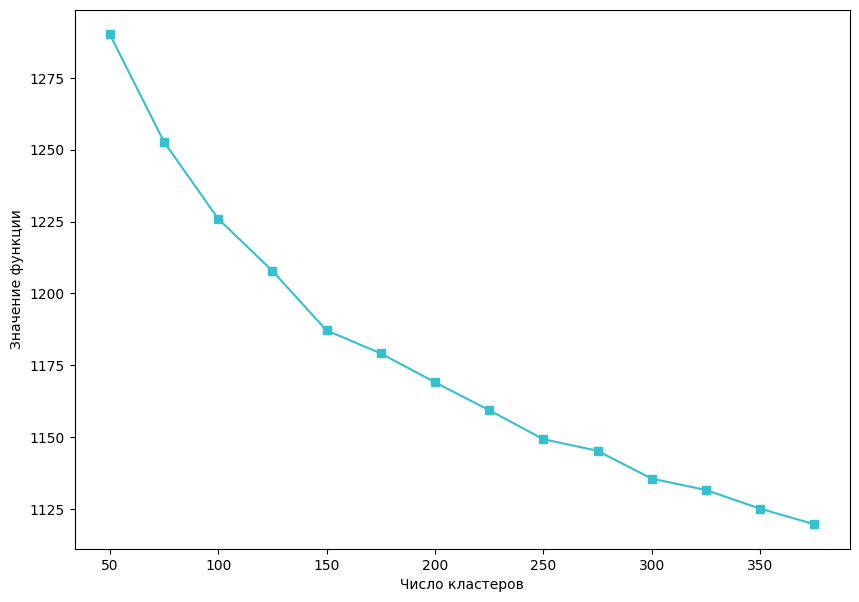

In [ ]:
cluster_count(mini_base, 50,400,25)

<div class="alert alert-block alert-warning">

Вывод предупреждений можно убрать с помощью:
    
import warnings 
    
warnings.filterwarnings('ignore')
</div>

Нужно определить точку разворота линии, после которой изменение становится менее существенным. Здесь предлагаю взять 150-160 и с помощью silhouette_score оценить качество кластеризации на этом промежутке.

<div class="alert alert-block alert-success">

Отлично, оптимальное число кластеров подобрано)
</div>

In [ ]:
def cluster_siluet(df, a, b):
    for n_cluster in range(a, b):
        kmeans = KMeans(n_clusters=n_cluster, random_state=12345).fit(df)
        label = kmeans.labels_
        sil_coeff = silhouette_score(df, label, metric='euclidean')
        print("Для n_clusters={}, коэффициент силуэта равен {}".format(n_cluster, sil_coeff))

In [ ]:
cluster_siluet(mini_base, 150, 160)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=150, коэффициент силуэта равен 0.05887762412992693


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=151, коэффициент силуэта равен 0.0561466778167653


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=152, коэффициент силуэта равен 0.06748857069587898


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=153, коэффициент силуэта равен 0.06187953941472855


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=154, коэффициент силуэта равен 0.05875262426530921


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=155, коэффициент силуэта равен 0.06023319731042692


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=156, коэффициент силуэта равен 0.07259672092645067


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=157, коэффициент силуэта равен 0.05821344494947732


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=158, коэффициент силуэта равен 0.057514184058185515


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Для n_clusters=159, коэффициент силуэта равен 0.05797250764686606


<div class="alert alert-block alert-warning">

При выводе значений метрики можно оставить 2-3 знака после запятой. Дл яэтого можно использовать f-строки и метод .format(). 
    
Подробнее про .format() и f-строки можно посмотреть:

1. https://pythonworld.ru/osnovy/formatirovanie-strok-metod-format.html 
2. https://docs-python.ru/tutorial/operatsii-tekstovymi-strokami-str-python/stroki-formatirovannye-stroki/
</div>

Коэффициент силуэта выше при делении на 156 кластеров. Также подберём оптимальное значение nprobe.

In [ ]:
dims_156 = df_base_del_19_scaler.shape[1]
n_cells = 156
quantizer_156 = faiss.IndexFlatL2(dims_156)
idx_l2 = faiss.IndexIVFFlat(quantizer_156, dims_156, n_cells)

In [ ]:
idx_l2.nprobe = 180

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_19_scaler[:60000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_19_scaler).astype('float32'))

CPU times: user 2.41 s, sys: 234 ms, total: 2.64 s
Wall time: 2.3 s


In [ ]:
%%time
r, idx = idx_l2.search(np.ascontiguousarray(df_train_del_19_scaler).astype('float32'), candidate_number)

CPU times: user 2min 52s, sys: 304 ms, total: 2min 53s
Wall time: 2min 8s


In [ ]:
acc = 0
for target, el in zip(targets_train.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 79.0%


<div class="alert alert-block alert-success">

 👍👍👍
</div>

##Проверка на валидационной выборке

Обрабатываем данные по аналогии с трейном

In [ ]:
targets_valid = answers['Expected']

In [ ]:
df_valid_clean = df_valid.drop_duplicates()
df_valid_clean = df_valid.drop(['25', '21', '33', '70', '6', '44', '59', '65','19'], axis=1)

In [ ]:
df_base_del_19_scaler = scaler.fit_transform(df_base_del_19)
df_valid_scaler = scaler.transform(df_valid_clean)

In [ ]:
dims_valid = df_base_del_19_scaler.shape[1] # размер индексных векторов
n_cells = 156
quantizer_valid = faiss.IndexFlatL2(dims_valid) # индекс для присвоения векторов определенному кластеру
idx_l2 = faiss.IndexIVFFlat(quantizer_valid, dims_valid, n_cells)

In [ ]:
idx_l2.nprobe = 180

In [ ]:
%%time
idx_l2.train(np.ascontiguousarray(df_base_del_19_scaler).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_del_19_scaler).astype('float32'))

CPU times: user 2.6 s, sys: 375 ms, total: 2.97 s
Wall time: 4.88 s


In [ ]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_valid_scaler).astype('float32'), candidate_number)

In [ ]:
acc = 0
for target, el in zip(targets_valid.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 78.2%


<div class="alert alert-block alert-success">

Дополнительно по этой теме можно посмотреть: https://spatial.usc.edu/wp-content/uploads/2014/03/gislabtr8.pdf
</div>

На валидационной выборке метрика упала с 79 до 78.2 %, но разница не значительная.  

##Вывод

Разработан алгоритм, который находит 5 похожих товаров для всех товаров из `validation.csv`.

Значение целевой метрики `accuracy@5` 78.2% на валидационно выборке  достигнуто с использованием индекса `IndexFlatL2` модели `FAISS` и следующего алгоритма:

- данные смасштабированны с помощью `RobustScaler` (устойчив к выбросам, которые есть в данных);
- удалены признаки с ненормальным распределением;
- кол-во кластеров: 156;
- `nprobe` = 180.

###Возможные доработки  
- Разбивка кластеров на подкластеры
- Тестирование разных видов расстояний - манхэттенское, косинусное и т д


<div class="alert alert-block alert-success">

Отлично, итоговый вывод сформулирован)
    
Молодец, что предложила рекомендации по дальнейшему улучшению качества модели.
    
</div>